# Part 1: Clustering the Tissues based on logOR values

In [1]:
from isotools import Transcriptome
from isotools import __version__ as isotools_version
from isotools._utils import _filter_event

import os
from pathlib import Path
import logging
from collections import Counter
from urllib.request import urlretrieve
import itertools
from tqdm.notebook import tqdm_notebook as tqdm

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pysam

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)
logger=logging.getLogger('isotools')
logger.info(f'This is isootools version {isotools_version}')

INFO:This is isootools version 0.2.11rc1


In [2]:
def eval_trid(df):
    df.priA_priB_trID=[eval(e) for e in df.priA_priB_trID]
    df.priA_altB_trID=[eval(e) for e in df.priA_altB_trID]
    df.altA_priB_trID=[eval(e) for e in df.altA_priB_trID]
    df.altA_altB_trID=[eval(e) for e in df.altA_altB_trID]
    pass

In [3]:
tissue_names=['left ventricle myocardium superior', 'Right ventricle myocardium superior',
              'mucosa of descending colon', 'heart left ventricle',
              'posterior vena cava', 'left cardiac atrium',
              'aorta', 'ovary', 'adrenal gland',
              'mesenteric fat pad', 'upper lobe of right lung',
              'heart right ventricle', 'left ventricle myocardium inferior',
              'left colon', 'right cardiac atrium',
              'lower lobe of right lung', 'lower lobe of left lung',
              'kidney', 'psoas muscle',
              'Right ventricle myocardium inferior', 'cardiac septum']

In [4]:
tbl_path="./tables/tissue/"
files=[x.name for x in Path(tbl_path).iterdir()]

tissue_dict={}

for tissue in tissue_names:
    
    tissue_key=tissue.replace(' ','_')
    fname=tissue_key+'.csv'
    
    logger.info(f"reading {fname}")
    tissue_dict[tissue]=pd.read_csv(tbl_path+fname)
    eval_trid(tissue_dict[tissue])

INFO:reading left_ventricle_myocardium_superior.csv
INFO:reading Right_ventricle_myocardium_superior.csv
INFO:reading mucosa_of_descending_colon.csv
INFO:reading heart_left_ventricle.csv
INFO:reading posterior_vena_cava.csv
INFO:reading left_cardiac_atrium.csv
INFO:reading aorta.csv
INFO:reading ovary.csv
INFO:reading adrenal_gland.csv
INFO:reading mesenteric_fat_pad.csv
INFO:reading upper_lobe_of_right_lung.csv
INFO:reading heart_right_ventricle.csv
INFO:reading left_ventricle_myocardium_inferior.csv
INFO:reading left_colon.csv
INFO:reading right_cardiac_atrium.csv
INFO:reading lower_lobe_of_right_lung.csv
INFO:reading lower_lobe_of_left_lung.csv
INFO:reading kidney.csv
INFO:reading psoas_muscle.csv
INFO:reading Right_ventricle_myocardium_inferior.csv
INFO:reading cardiac_septum.csv


## Make event IDs

In [10]:
def make_event_ids(coor_tbl,progress_bar=True):
    
    event_ids=[]
    
    if progress_bar==True:
        for i,r in tqdm(coor_tbl.iterrows(),total=coor_tbl.shape[0]):
            event_ids.append(':'.join([r.ase1_type,r.ase2_type,str(r.ase1_start),
                                       str(r.ase1_end),str(r.ase2_start),str(r.ase2_end)]))
    else:
        for i,r in coor_tbl.iterrows():
            event_ids.append(':'.join([r.ase1_type,r.ase2_type,str(r.ase1_start),
                                       str(r.ase1_end),str(r.ase2_start),str(r.ase2_end)]))
        
    return event_ids

In [11]:
def make_group_ids(tabl_dict,progress_bar=True):
    group_ids={}
    
    if progress_bar==True:
        for k in tqdm(tabl_dict.keys()):
            group_ids[k]=make_event_ids(tabl_dict[k],progress_bar=False)
    else:
        for k in tabl_dict.keys():
            group_ids[k]=make_event_ids(tabl_dict[k],progress_bar=False)
    return group_ids

In [8]:
tissue_ids=make_group_ids(tissue_dict)

  0%|          | 0/21 [00:00<?, ?it/s]

In [10]:
for k,tab in tissue_dict.items():
    tab["pID"]=tissue_ids[k] # assign pair id

## Create the DataFrame for the Clustering

In [19]:
all_ids=[]
for k,tab in tissue_dict.items():
    all_ids.extend(list(tab.pID))
all_ids=list(set(all_ids))
print(len(all_ids))

27878


In [23]:
def make_cluster_df():
    
    data={k:[] for k in tissue_dict.keys()}
    
    error_count=0
    
    index=[]
    
    i=0
    for pid in tqdm(all_ids):
        for k,tab in tissue_dict.items():
            
            r=tab[tab.pID==pid]
            
            if r.shape[0]!=0:
                
                if r.shape[0]>1:
                    error_count+=1
                    print(f"errors encountered: {error_count}",end="\r")
                    data[k].append(pd.NA)
                else:    
                    data[k].append(float(r.log2OR))
            
            else:
                
                data[k].append(0.0)

    df=pd.DataFrame(data,index=all_ids)
    nrow=df.shape[0]
    df=df.dropna()
    print(f"number of rows dropped: {nrow-df.shape[0]}")
    df=df.astype("float64")
    
    return df

In [30]:
tabl_path="/project/hfa_work/ceraolo/theco/tables/clustering/"
files=[x.name for x in Path(tabl_path).iterdir()]

fname="raw_or.csv"

if fname not in files:
    df=make_cluster_df()
    df.to_csv(tabl_path+fname,index=False)

## Execute the Clustering

In [199]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 200
plt.style.use("seaborn-whitegrid")
figures="/project/hfa_work/ceraolo/theco/figures/or_clustering/brute/"

In [36]:
def make_clustering(df,method="average",dist="euclidean",figsize=(10,8),suf_title="",save=True):
    title=f"clustering_{method}_{dist}"+suf_title
    print(title)
    sns.clustermap(df.transpose(),metric=dist,method=method,xticklabels=False,figsize=figsize)
    
    fig.tight_layout()
    
    if save == True:
        plt.savefig(figures+title+".png")
        plt.close()
    else:
        plt.show()

### Trying all combinations of distance metric and linkage

In [33]:
dists=["braycurtis","euclidean", "canberra", "chebyshev", "cityblock", "correlation", "cosine", "dice", "hamming", "jaccard", "jensenshannon",
      "kulsinski", "kulczynski1", "mahalanobis", "matching", "minkowski", "rogerstanimoto", "russellrao", "seuclidean",
      "sokalmichener", "sokalsneath", "sqeuclidean", "yule"]

In [34]:
erratic_metrics=[]

clustering_average_braycurtis
clustering_average_euclidean
clustering_average_canberra
clustering_average_chebyshev
clustering_average_cityblock
clustering_average_correlation
clustering_average_cosine
clustering_average_dice
clustering_average_hamming
clustering_average_jaccard
clustering_average_jensenshannon
clustering_average_kulsinski
clustering_average_kulczynski1
clustering_average_mahalanobis
clustering_average_matching
clustering_average_minkowski
clustering_average_rogerstanimoto
clustering_average_russellrao
clustering_average_seuclidean
clustering_average_sokalmichener
clustering_average_sokalsneath


/pkg/python-3.9.12-0/lib/python3.9/site-packages/seaborn/matrix.py:805: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(figsize=figsize)


clustering_average_sqeuclidean
clustering_average_yule
clustering_complete_braycurtis
clustering_complete_euclidean
clustering_complete_canberra
clustering_complete_chebyshev
clustering_complete_cityblock
clustering_complete_correlation
clustering_complete_cosine
clustering_complete_dice
clustering_complete_hamming
clustering_complete_jaccard
clustering_complete_jensenshannon
clustering_complete_kulsinski
clustering_complete_kulczynski1
clustering_complete_mahalanobis
clustering_complete_matching
clustering_complete_minkowski
clustering_complete_rogerstanimoto
clustering_complete_russellrao
clustering_complete_seuclidean
clustering_complete_sokalmichener
clustering_complete_sokalsneath
clustering_complete_sqeuclidean
clustering_complete_yule
clustering_ward_braycurtis
clustering_ward_euclidean
clustering_ward_canberra
clustering_ward_chebyshev
clustering_ward_cityblock
clustering_ward_correlation
clustering_ward_cosine
clustering_ward_dice
clustering_ward_hamming
clustering_ward_jaccar

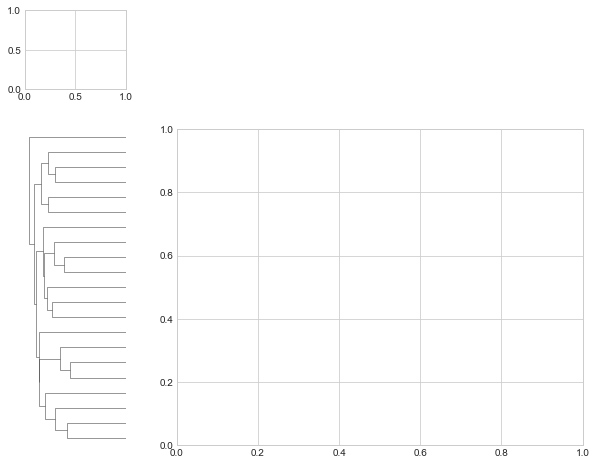

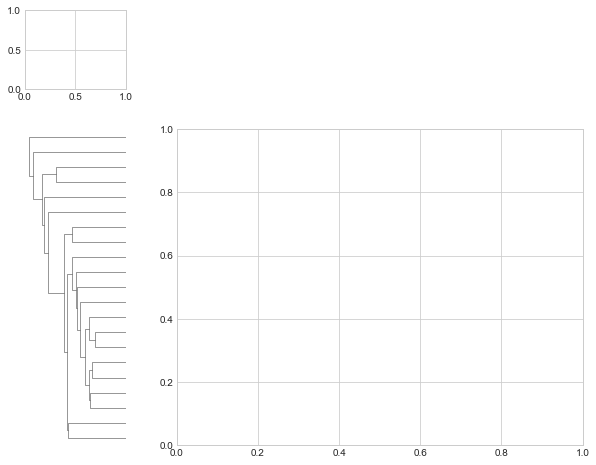

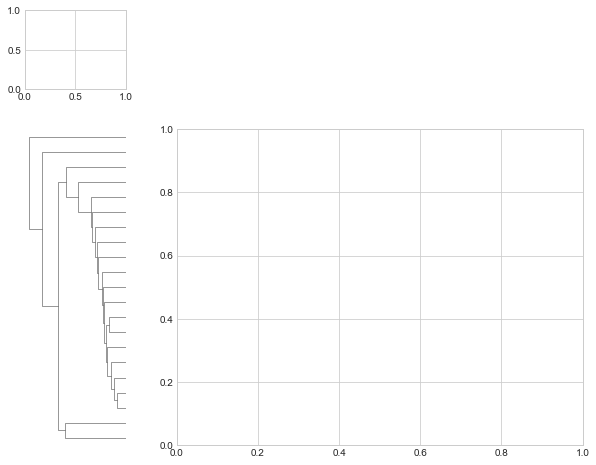

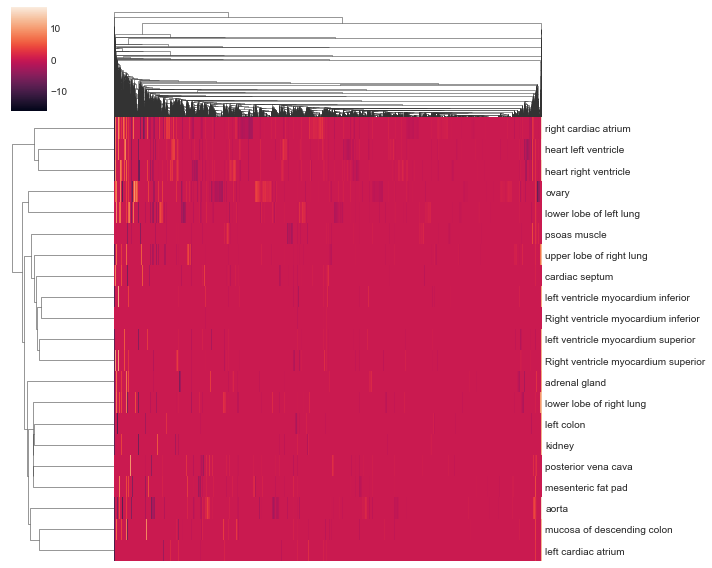

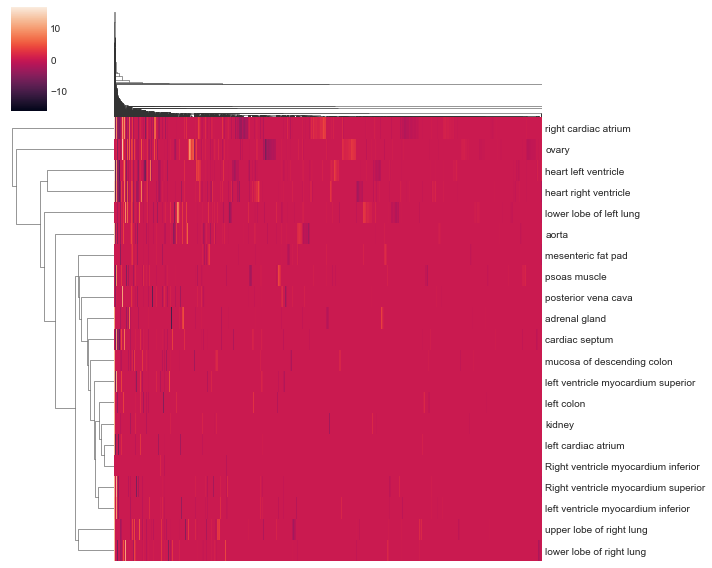

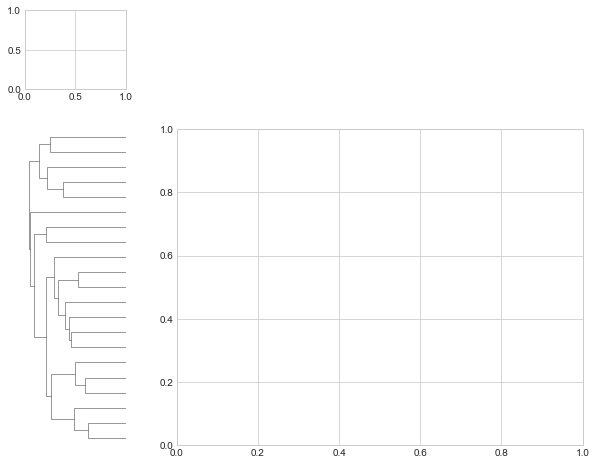

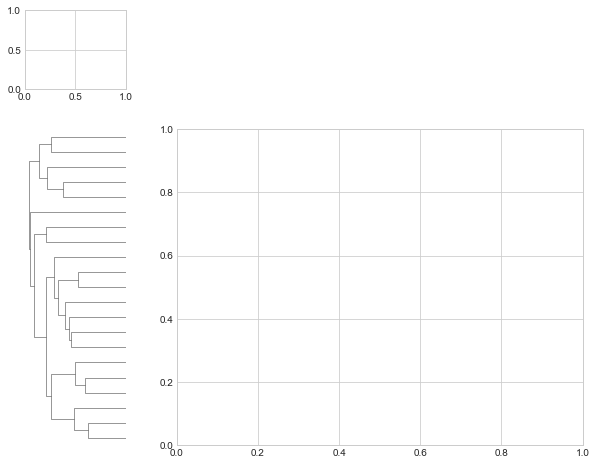

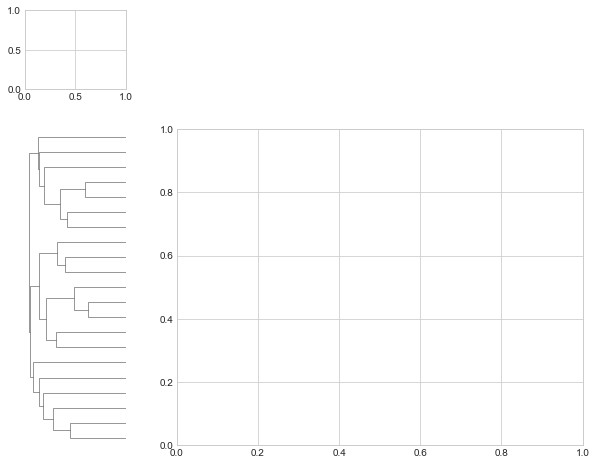

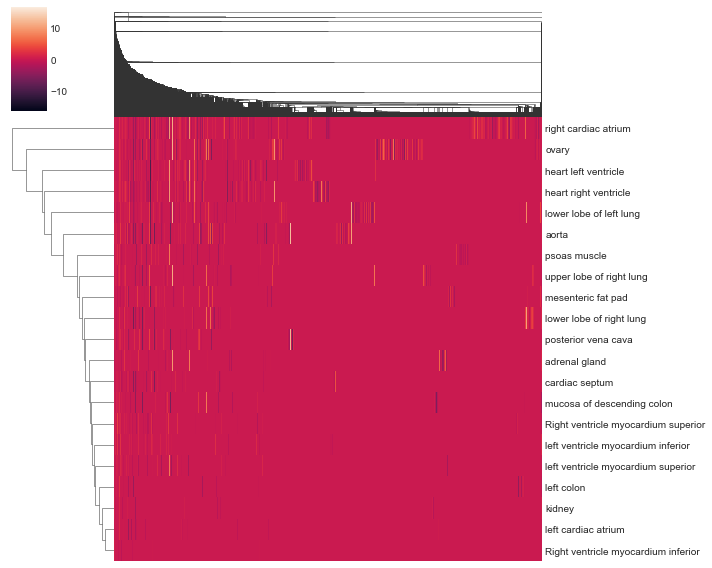

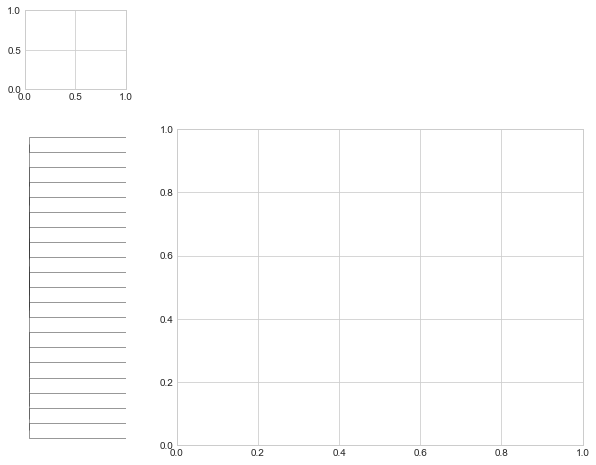

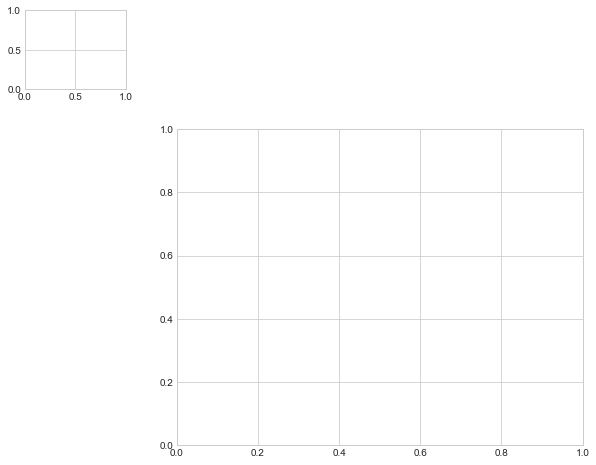

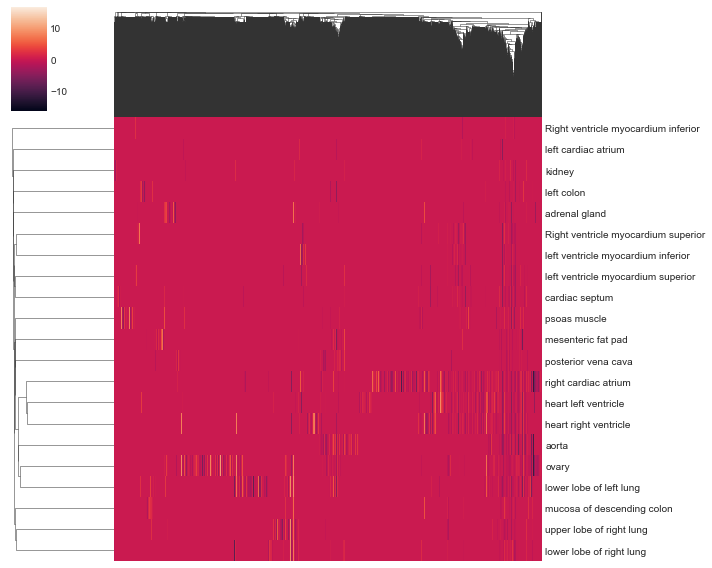

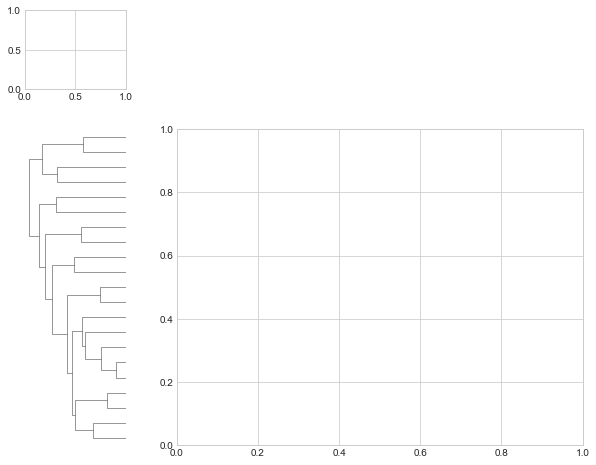

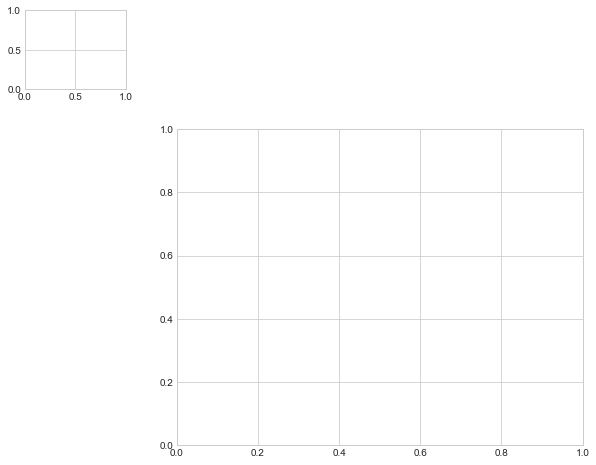

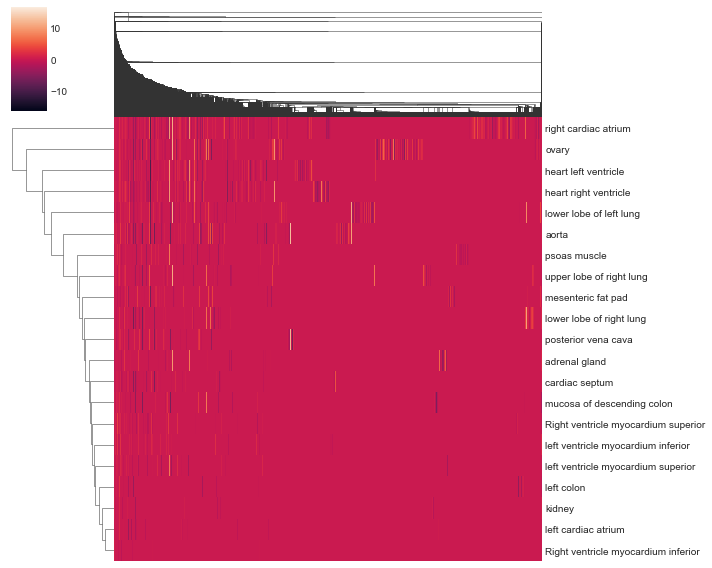

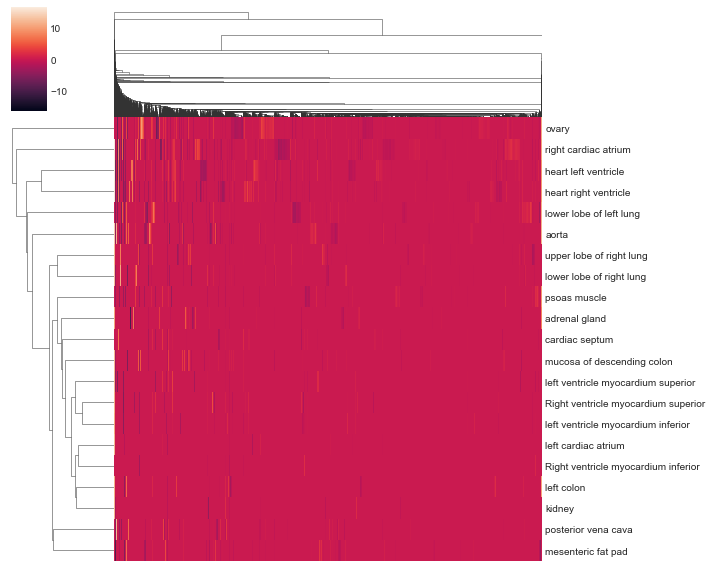

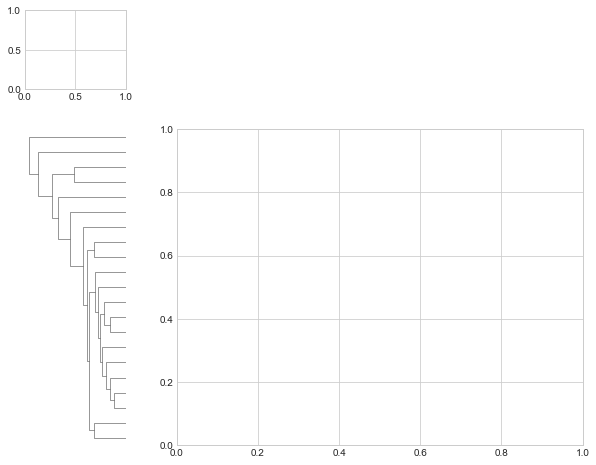

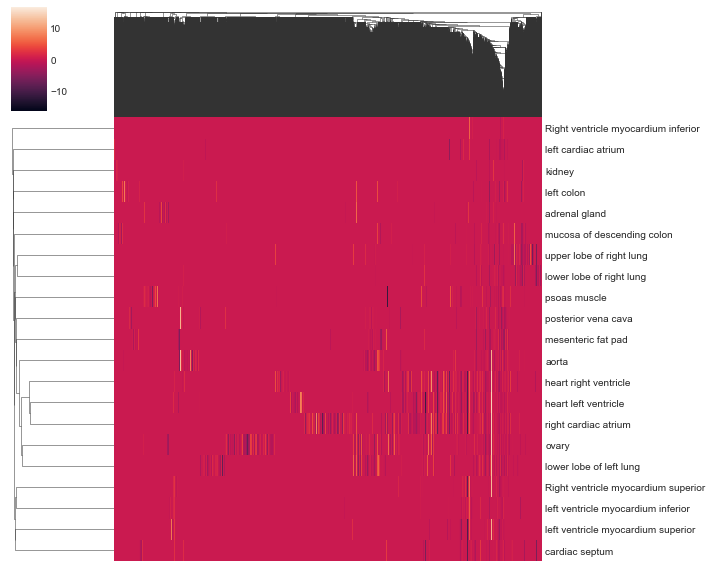

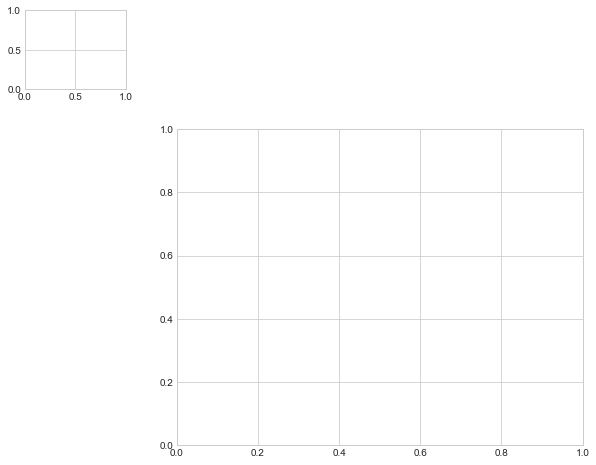

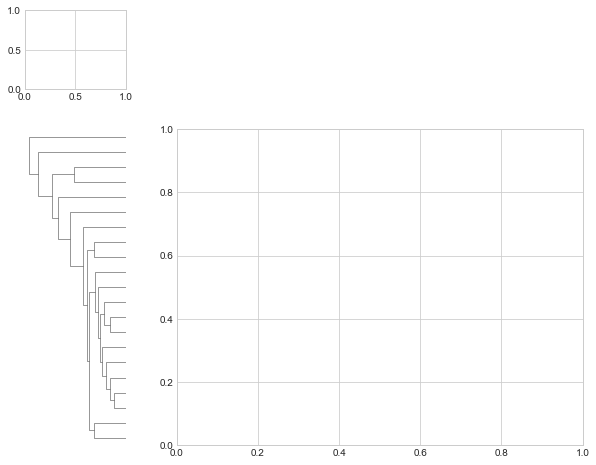

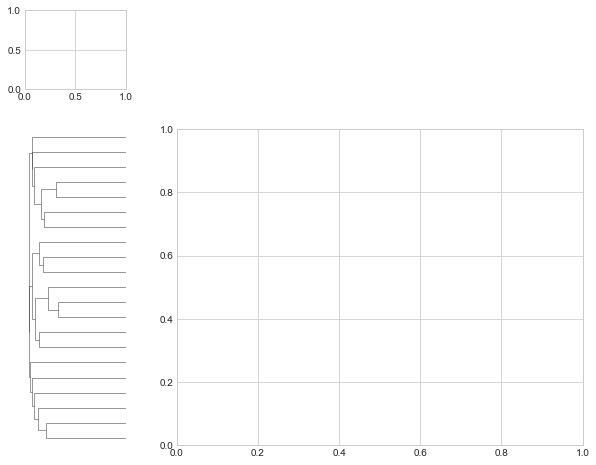

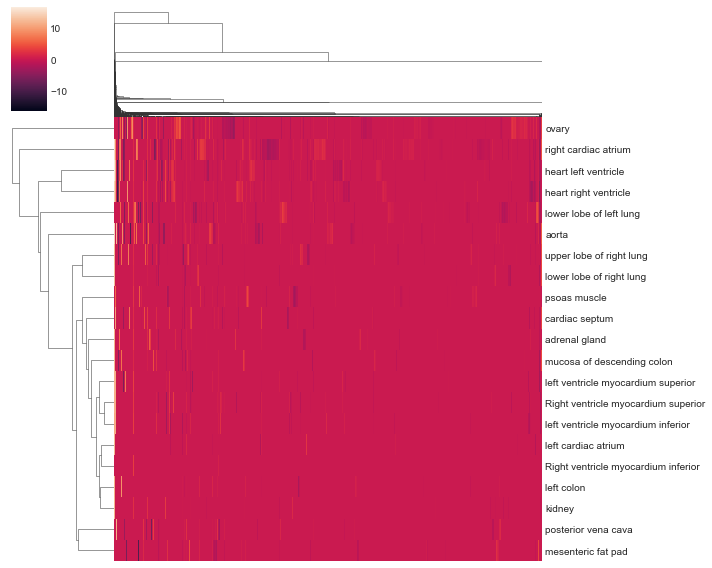

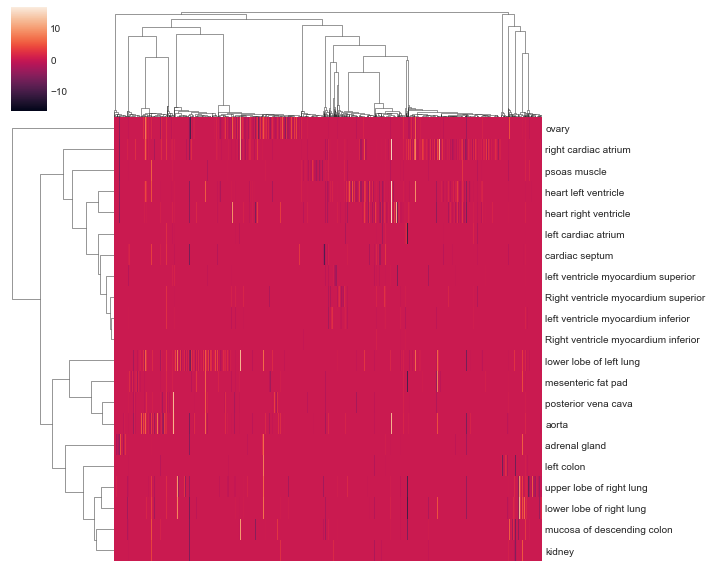

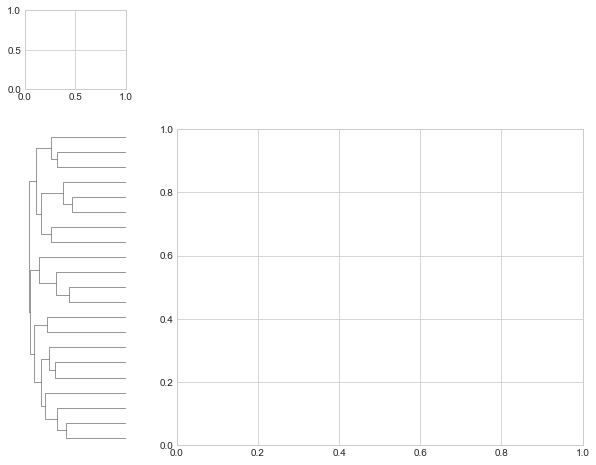

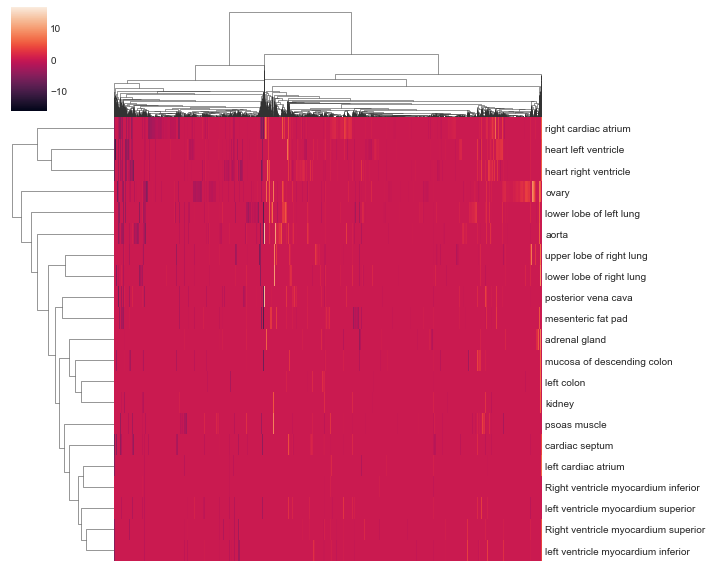

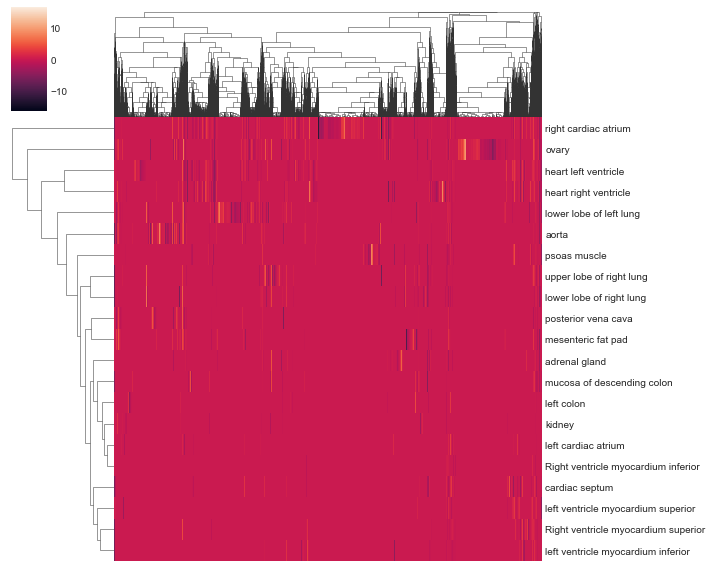

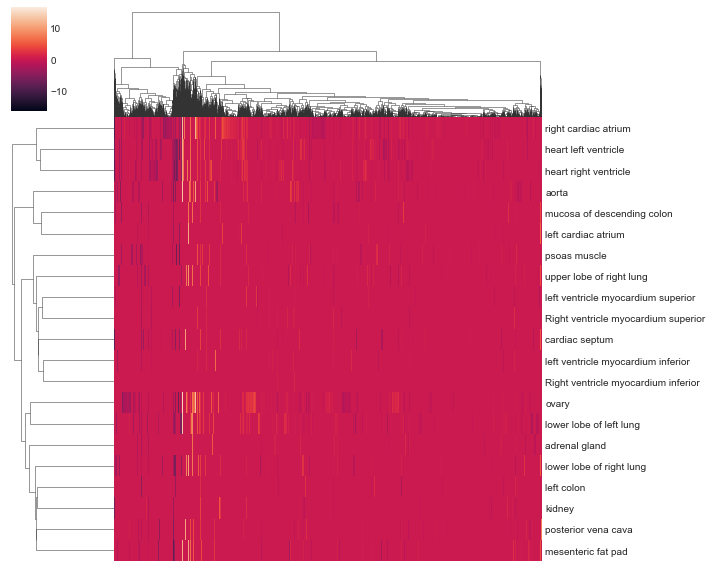

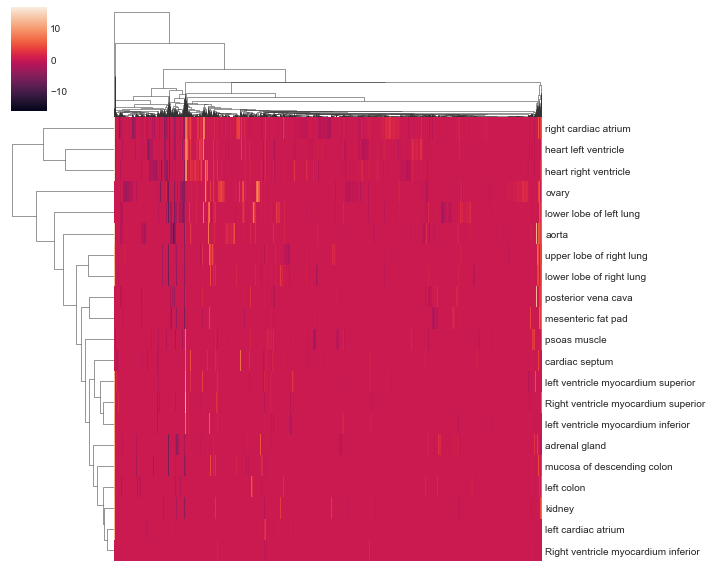

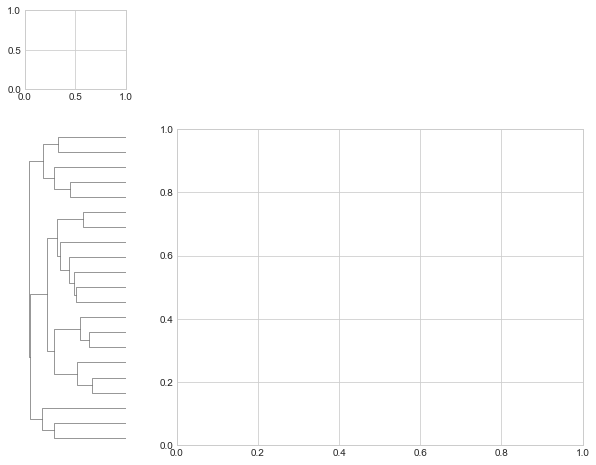

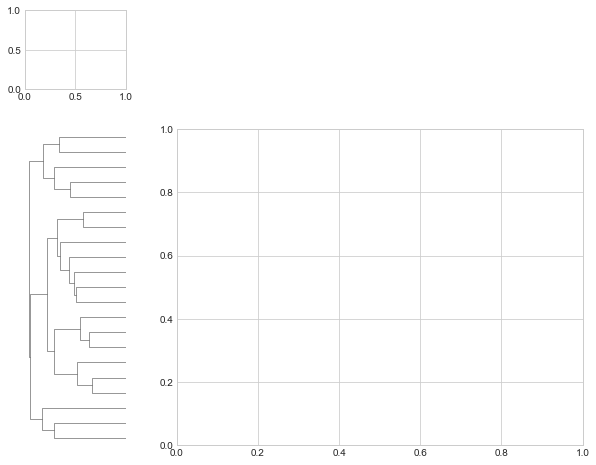

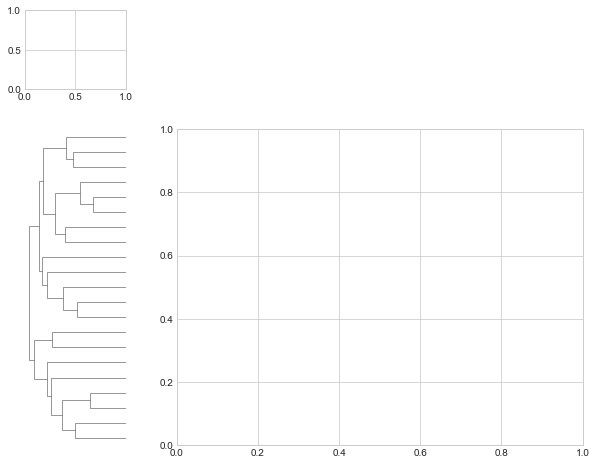

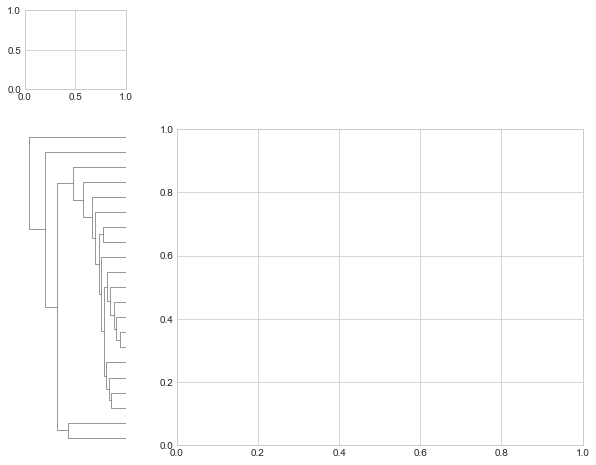

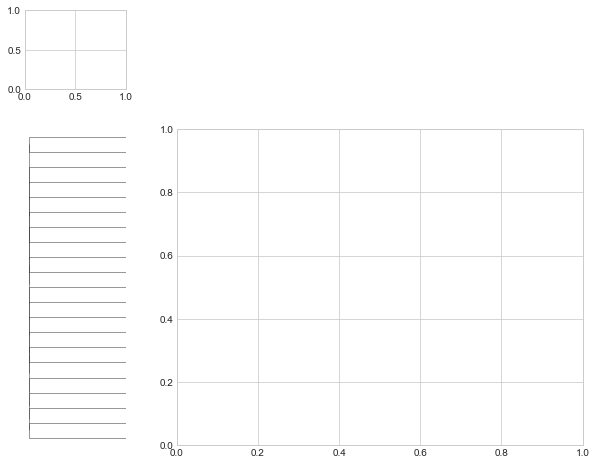

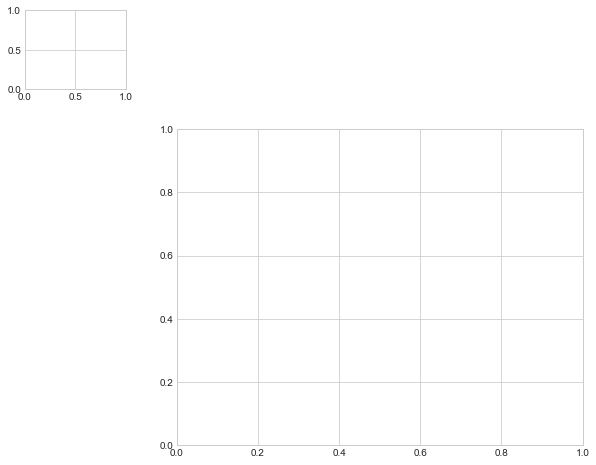

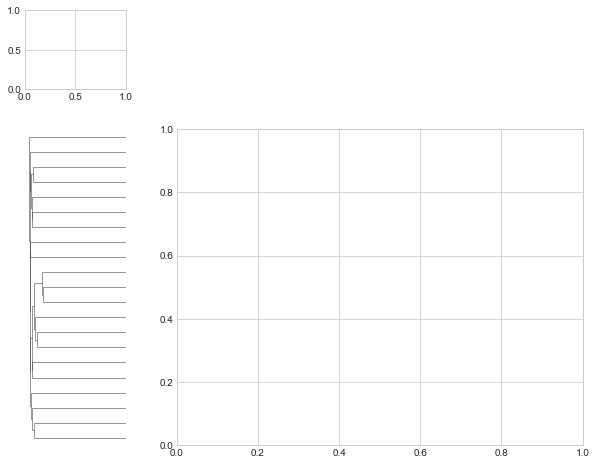

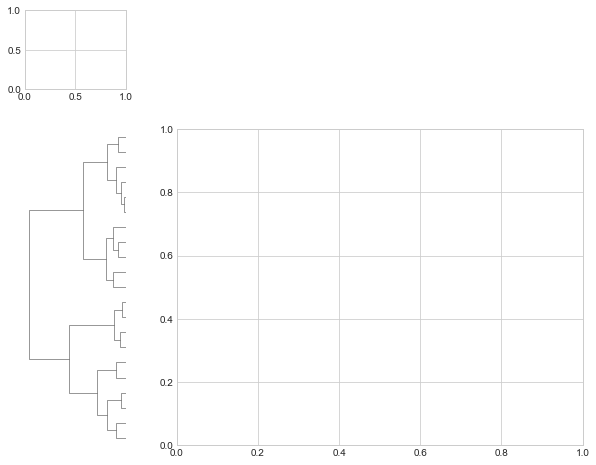

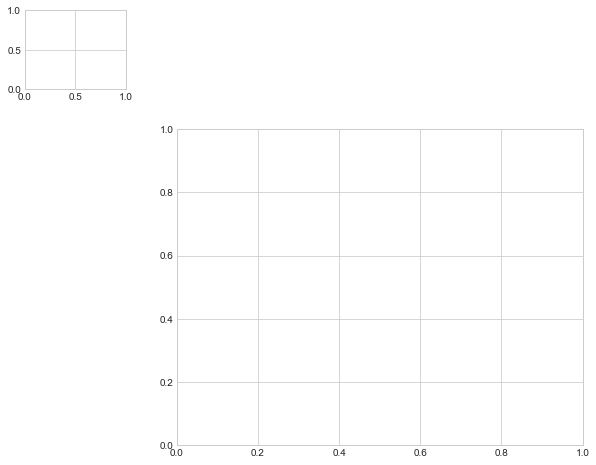

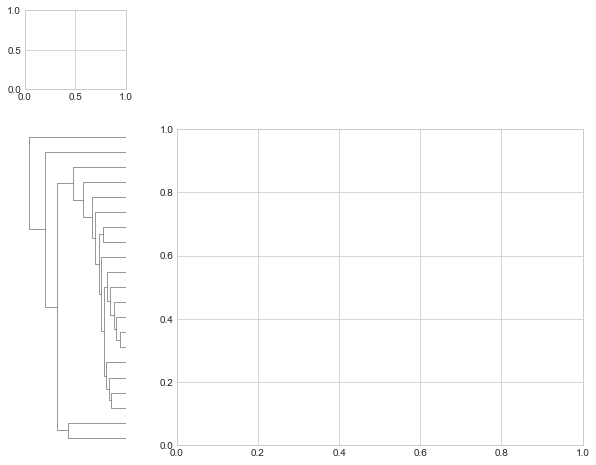

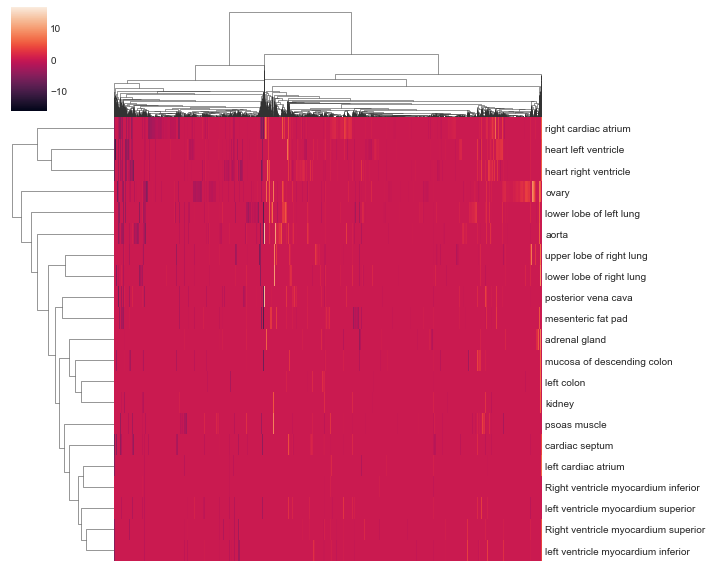

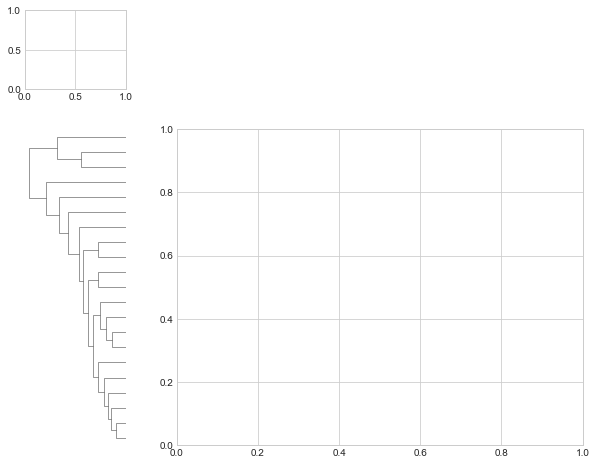

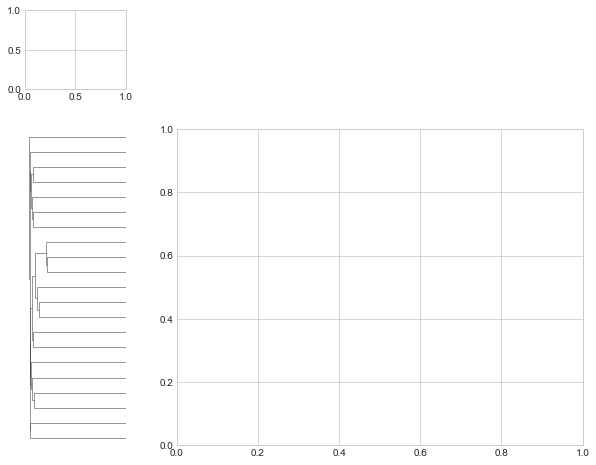

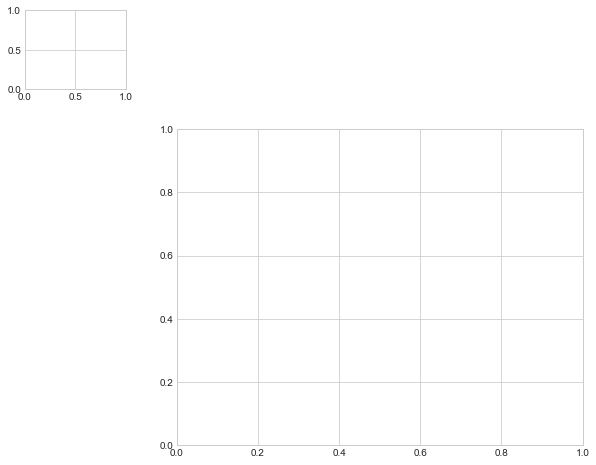

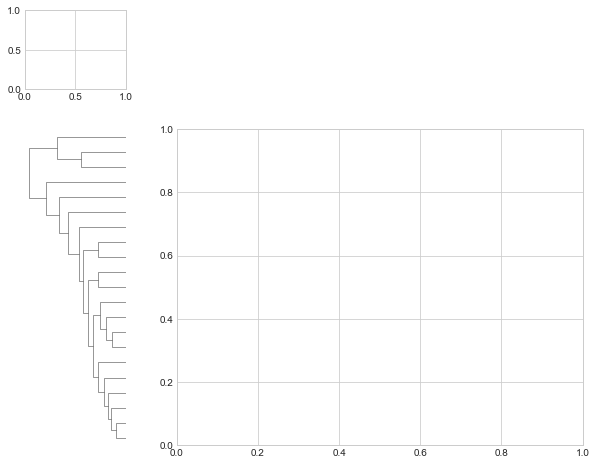

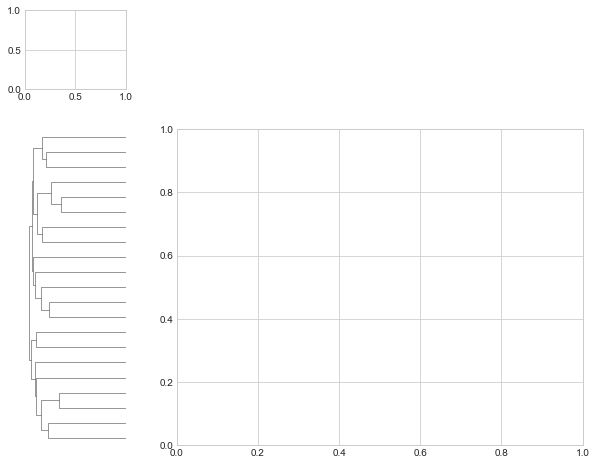

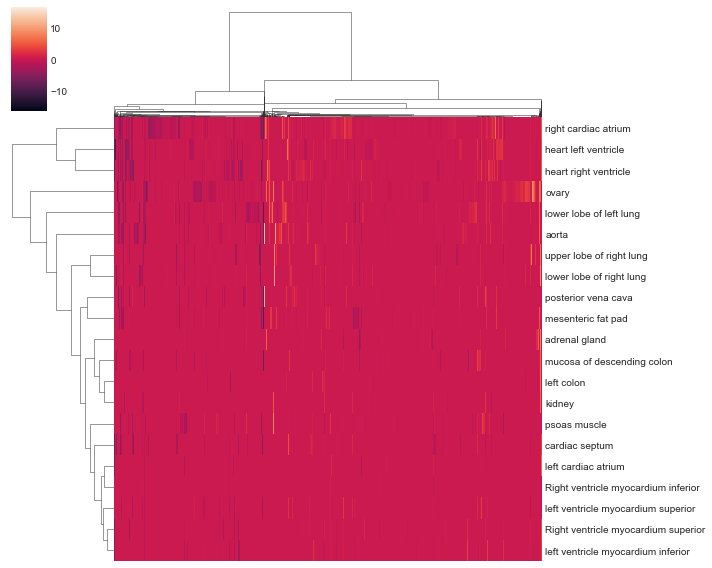

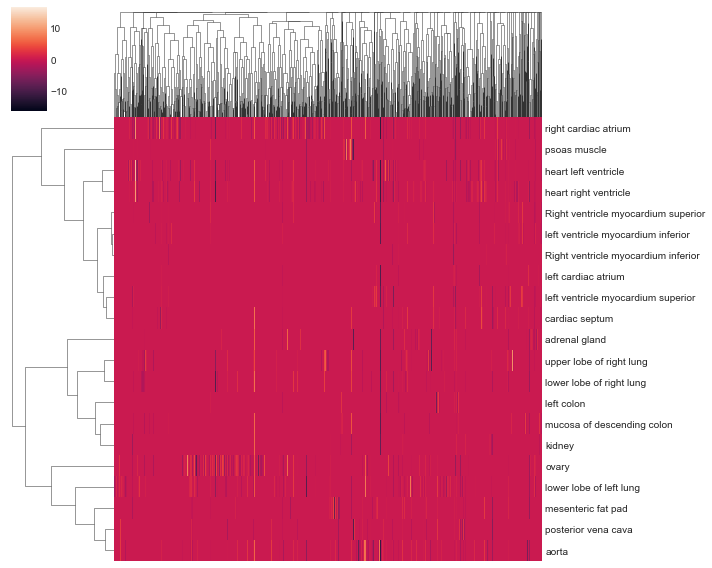

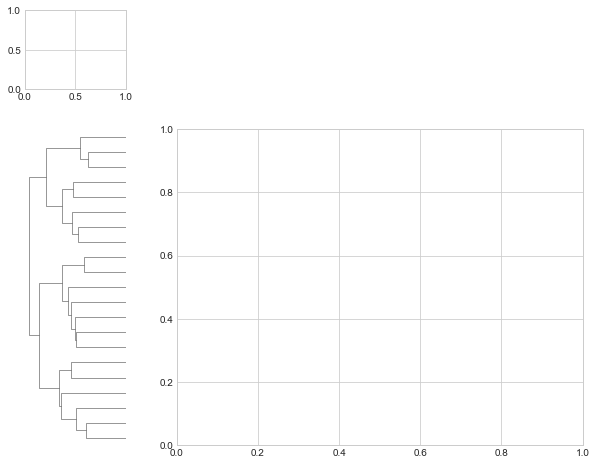

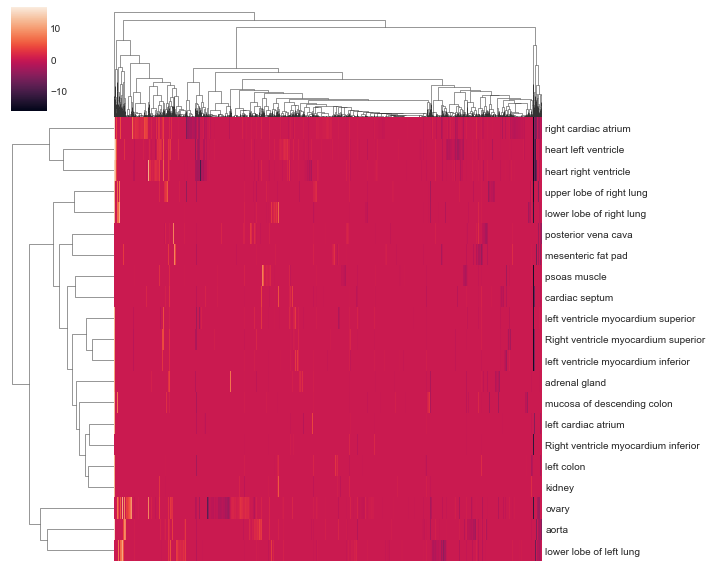

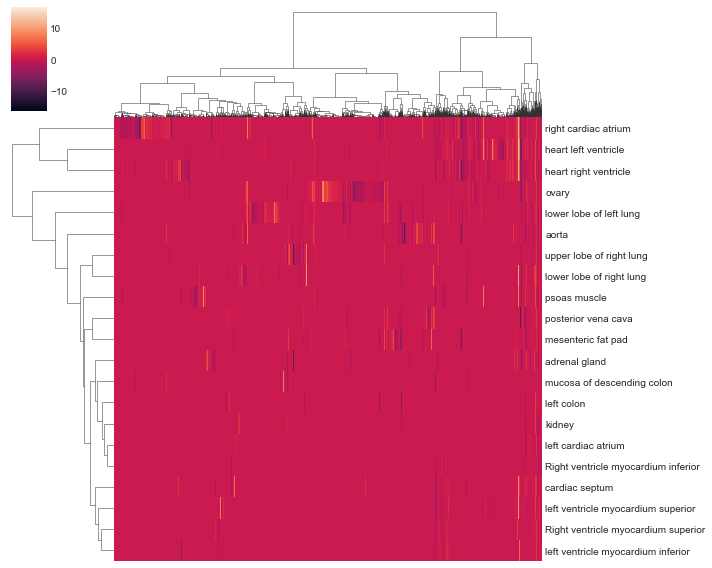

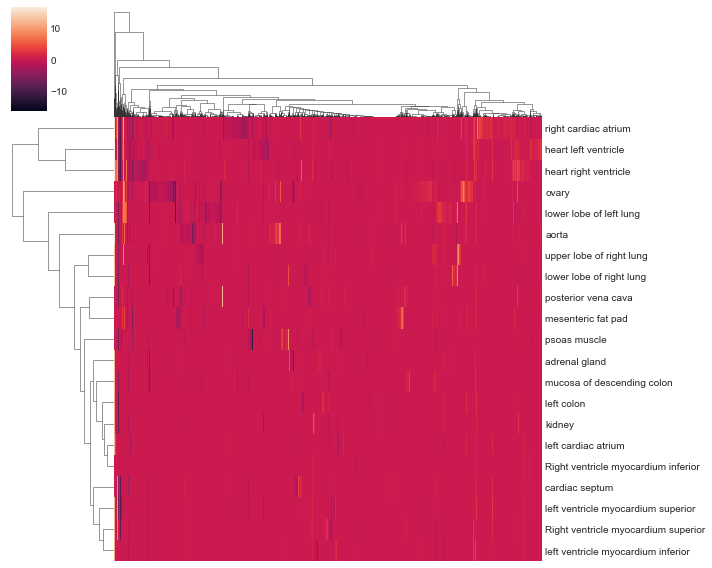

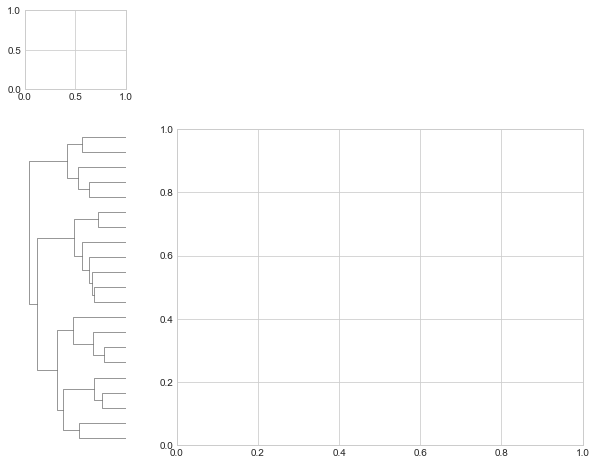

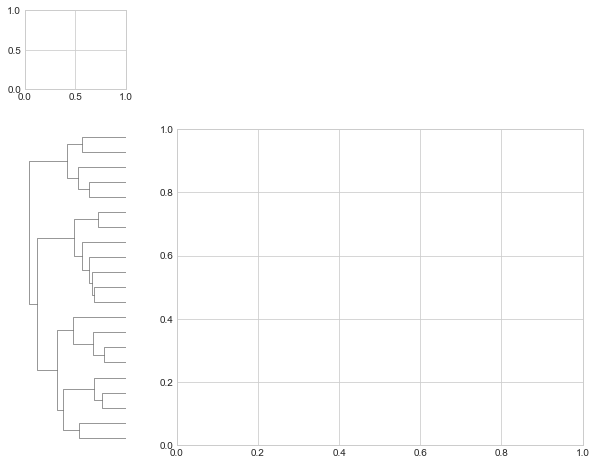

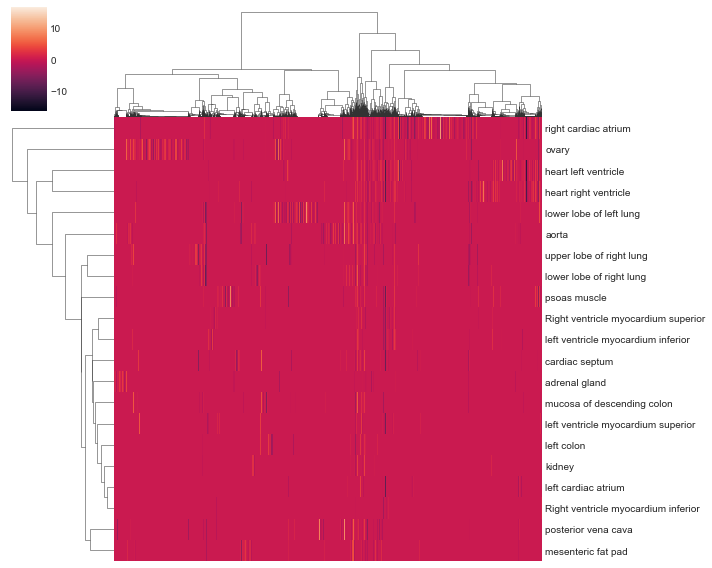

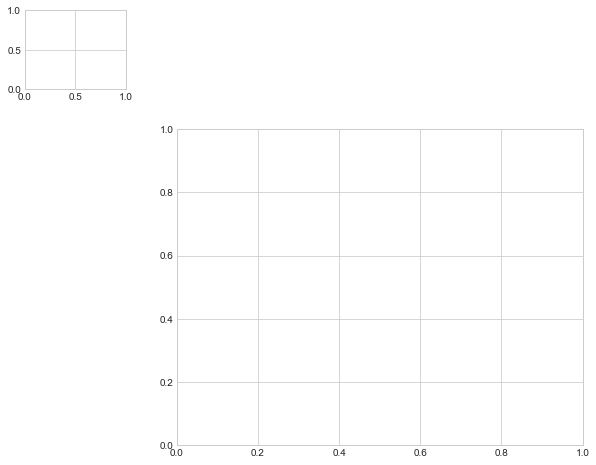

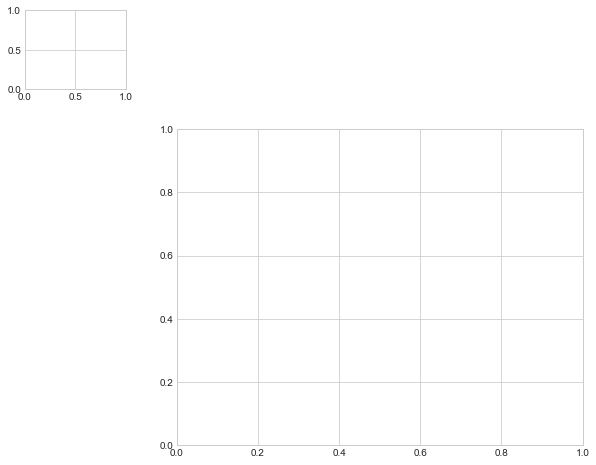

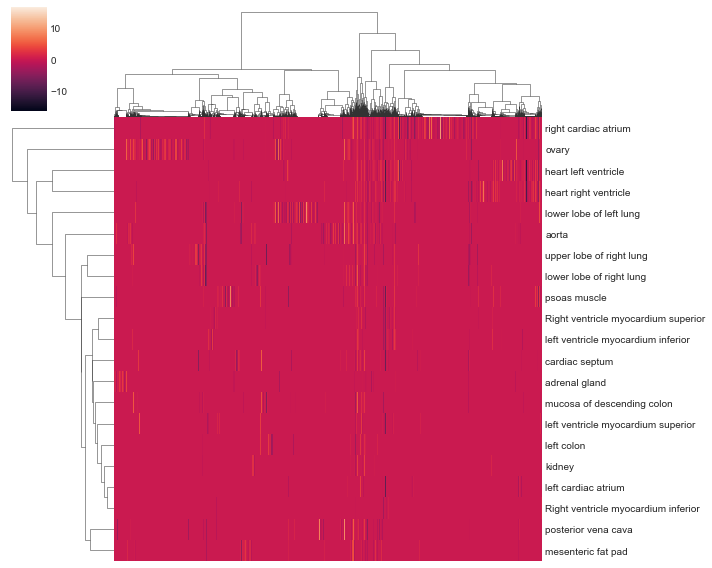

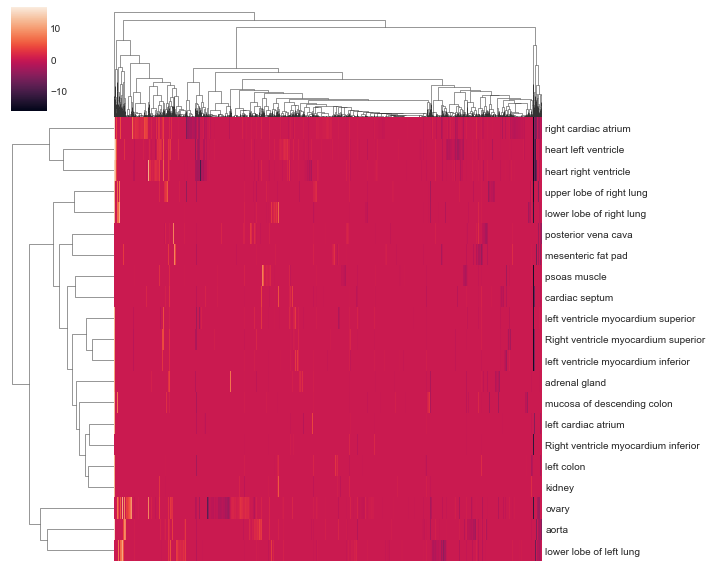

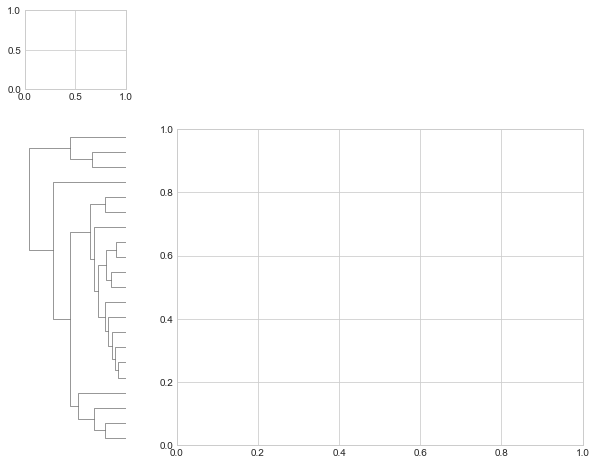

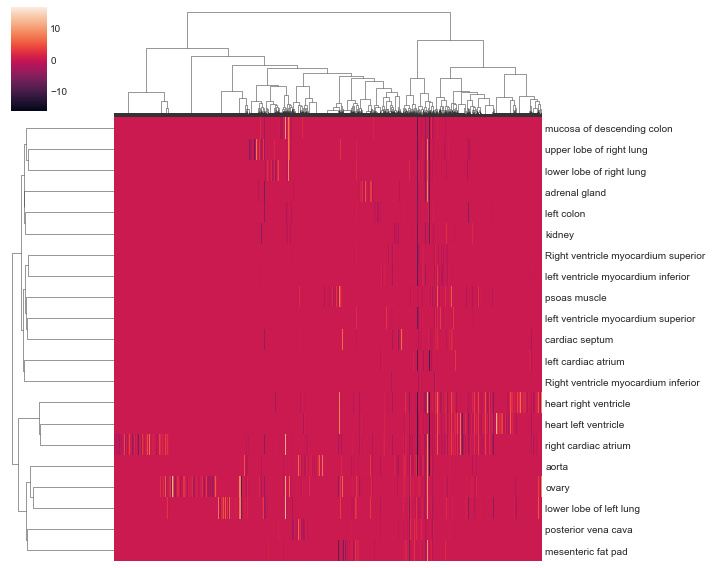

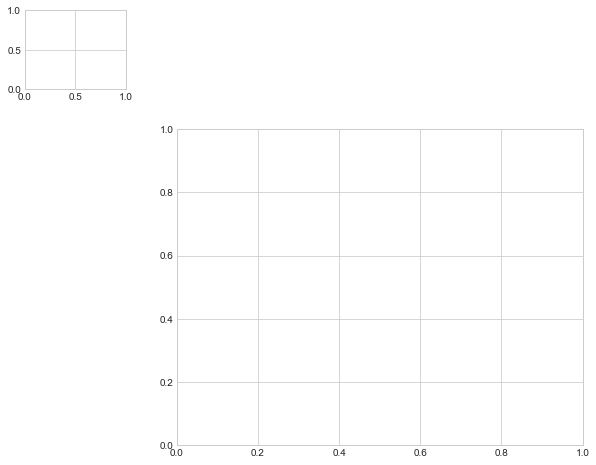

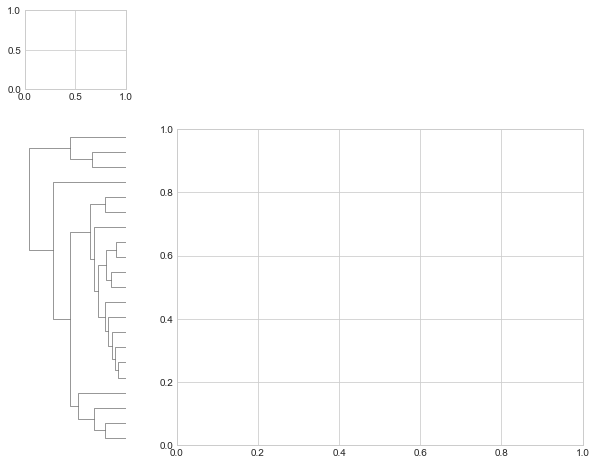

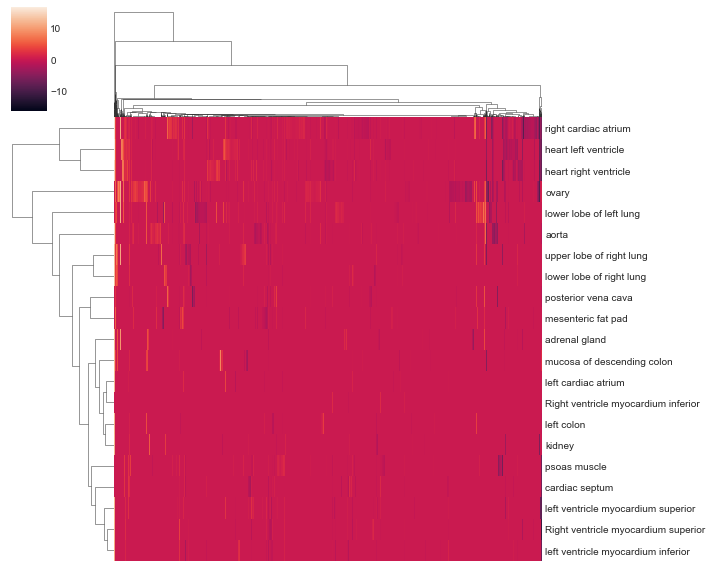

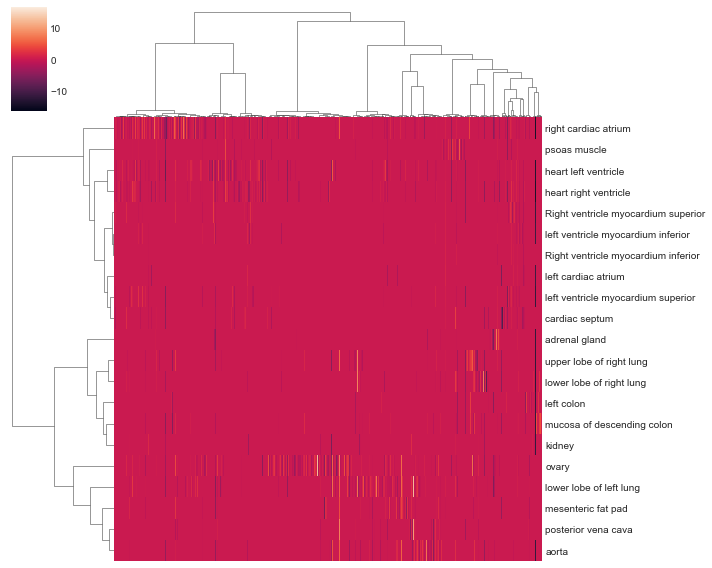

In [35]:
for method in ("average","complete","ward"):
    for dist in dists:
        try:
            make_clustering(df,method=method,dist=dist)
        except:
            erratic_metrics.append(dist)

Let's try again after normilizing the data.

In [168]:
norm_df=(df-df.mean())/df.std()

clustering_average_braycurtis_norm


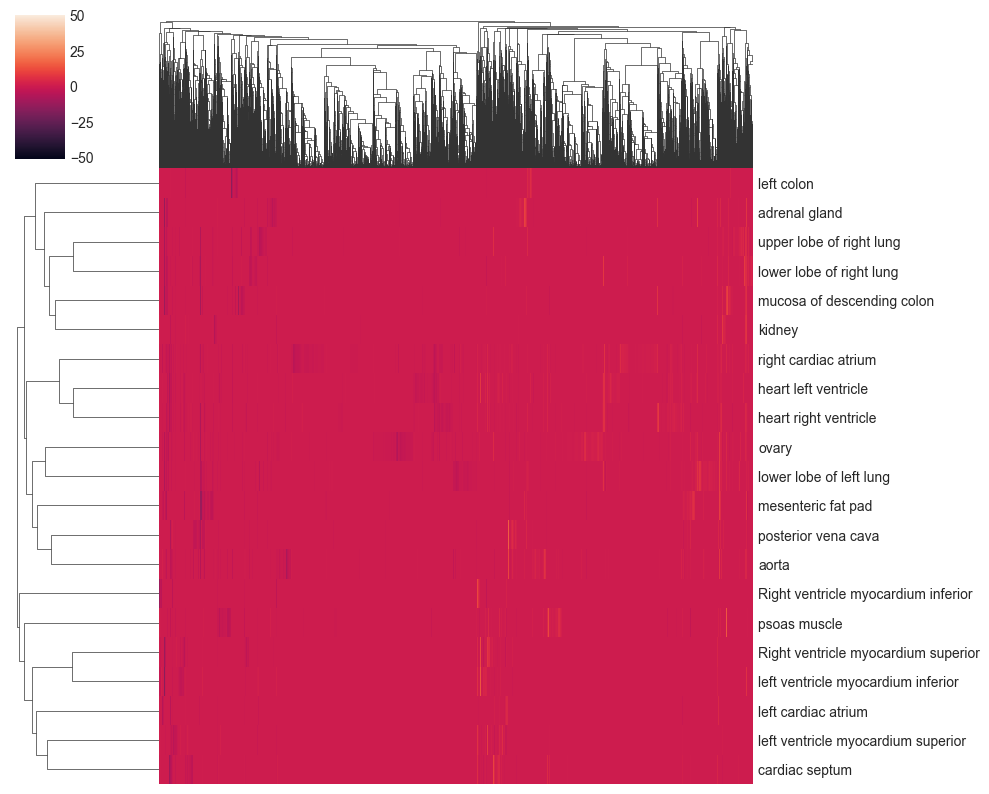

clustering_average_canberra_norm


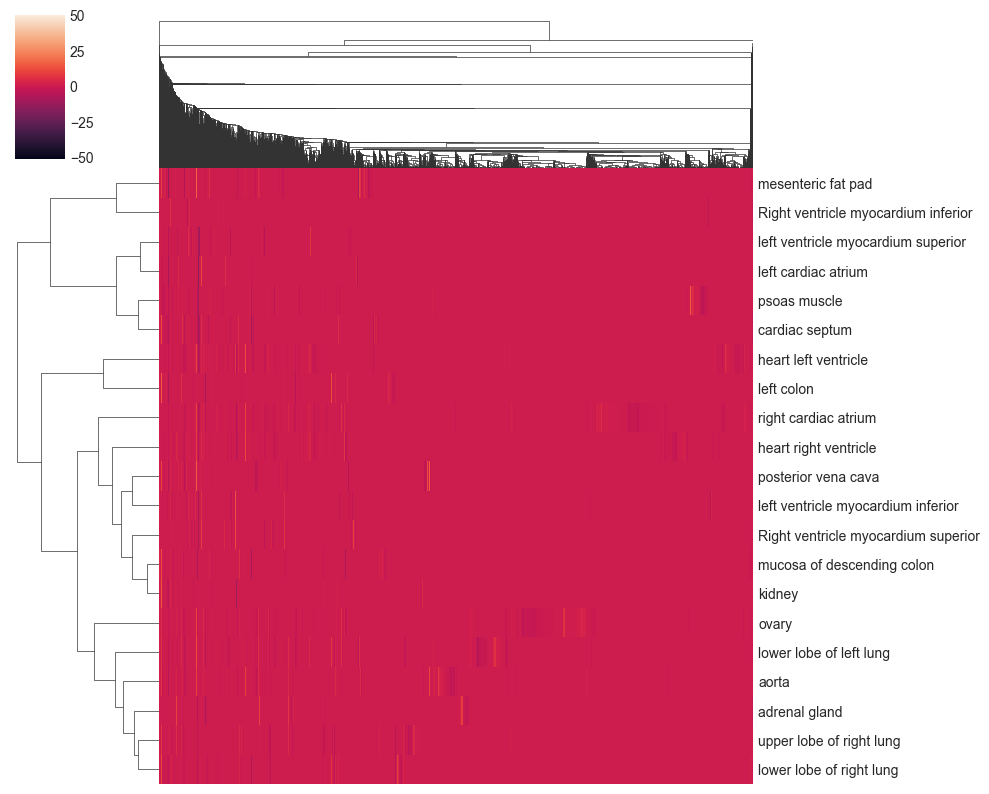

clustering_average_chebyshev_norm


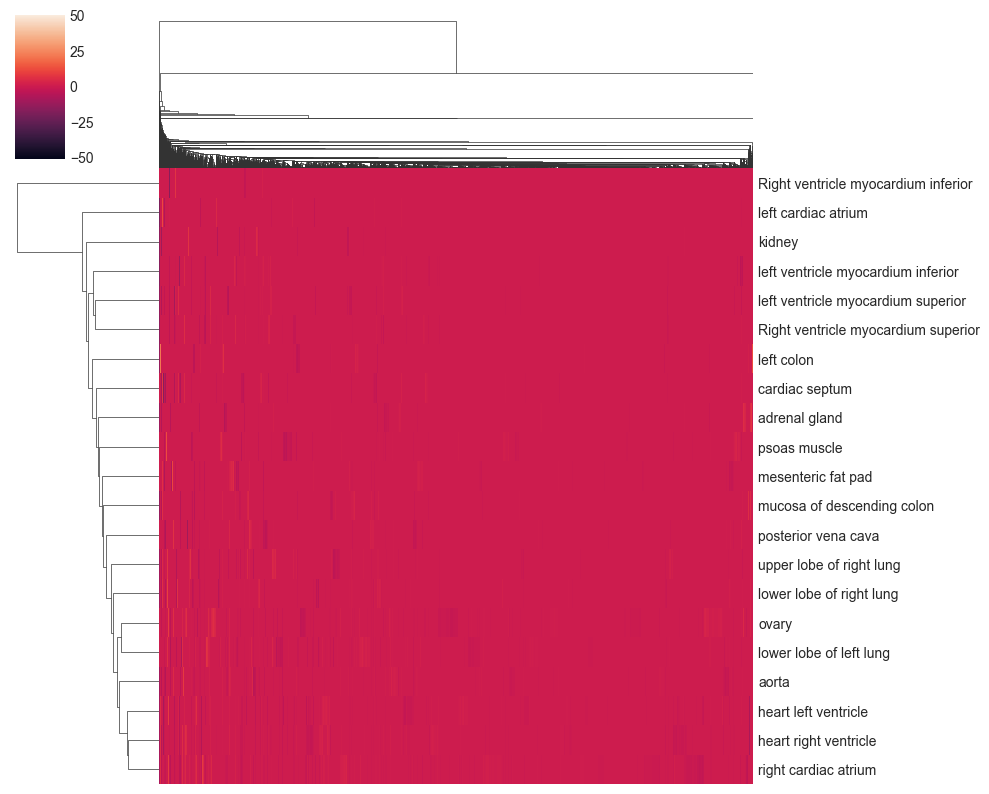

clustering_average_cityblock_norm


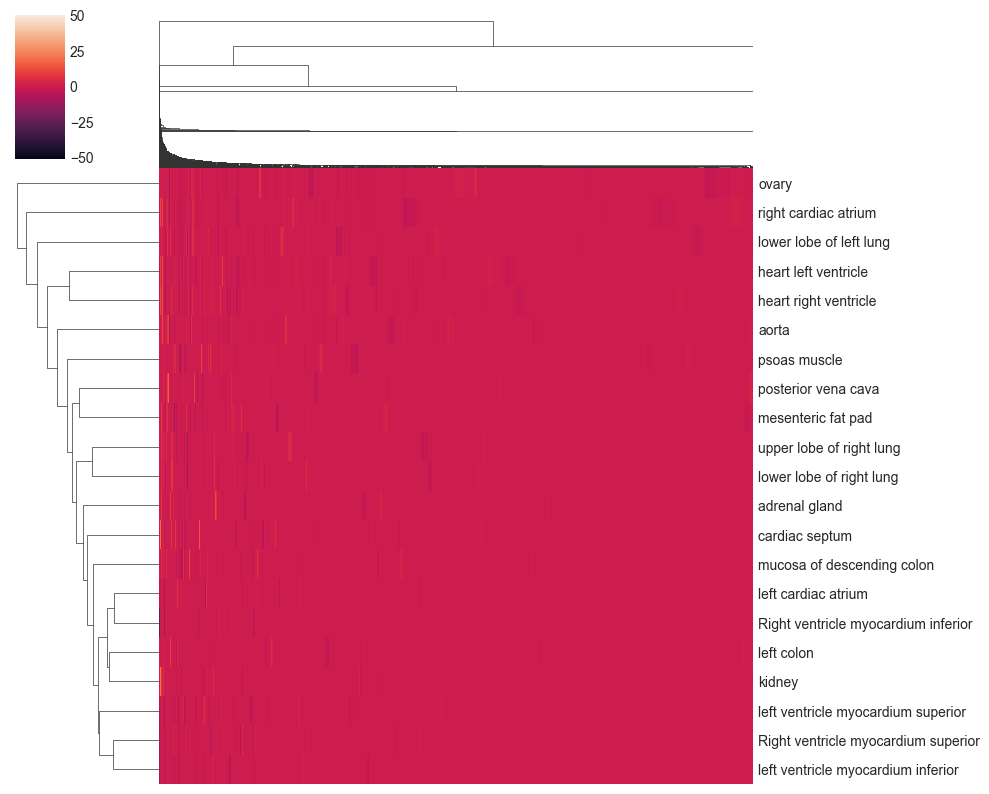

clustering_average_correlation_norm


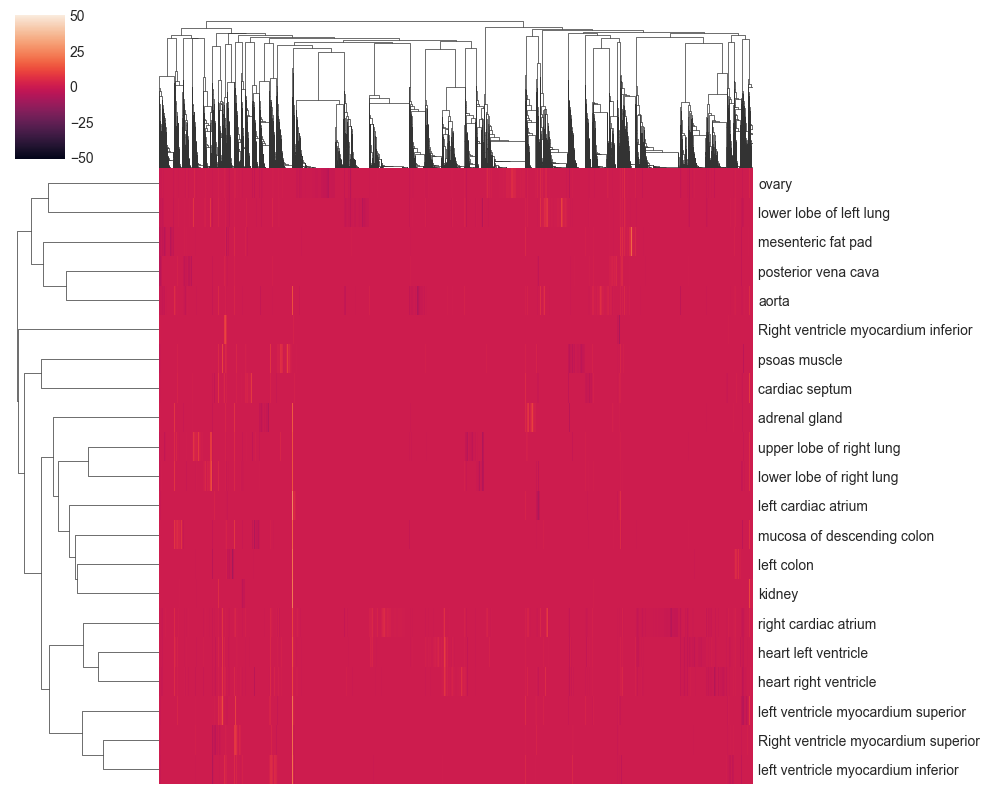

clustering_average_cosine_norm


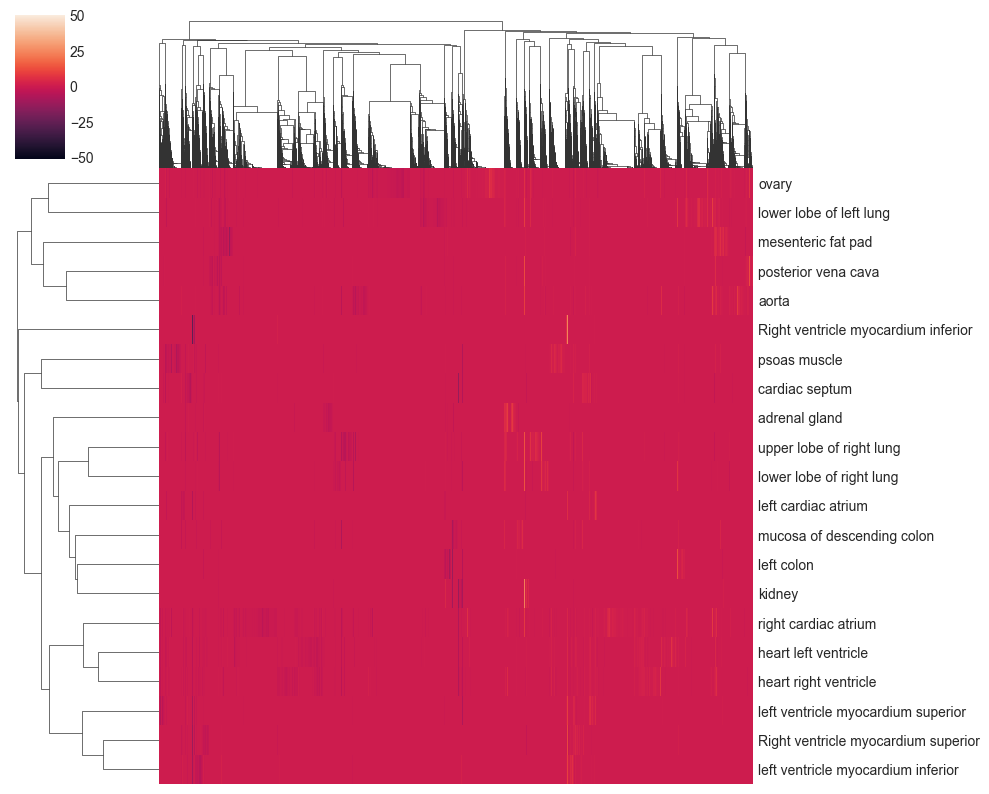

clustering_average_dice_norm


/pkg/python-3.9.12-0/lib/python3.9/site-packages/seaborn/matrix.py:709: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, max_dependent_coord * 1.05)


RecursionError: maximum recursion depth exceeded while getting the str of an object

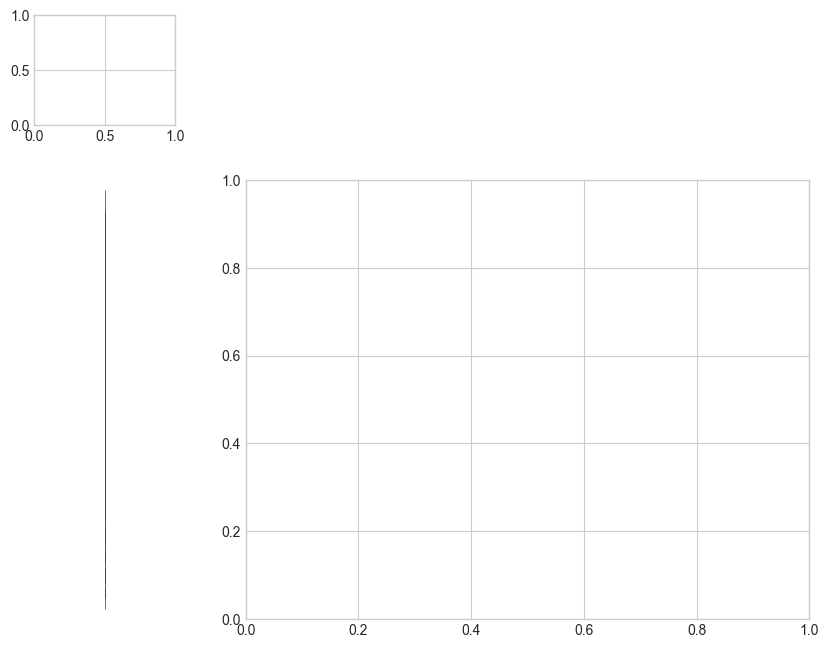

In [169]:
for method in ("average","complete","ward"):
    for dist in dists:
        make_clustering(norm_df,method=method,dist=dist,suf_title="_norm")

In [ ]:
norm_df=(df-df.min())/(df.max()-df.min())

In [ ]:
for method in ("average","complete","ward"):
    for dist in dists:
        make_clustering(norm_df,method=method,dist=dist,suf_title="_minmaxnorm")

The results don't seem promising at all. Different metric don't seem to give significantly different 

AttributeError: 'QuadMesh' object has no property 'p'

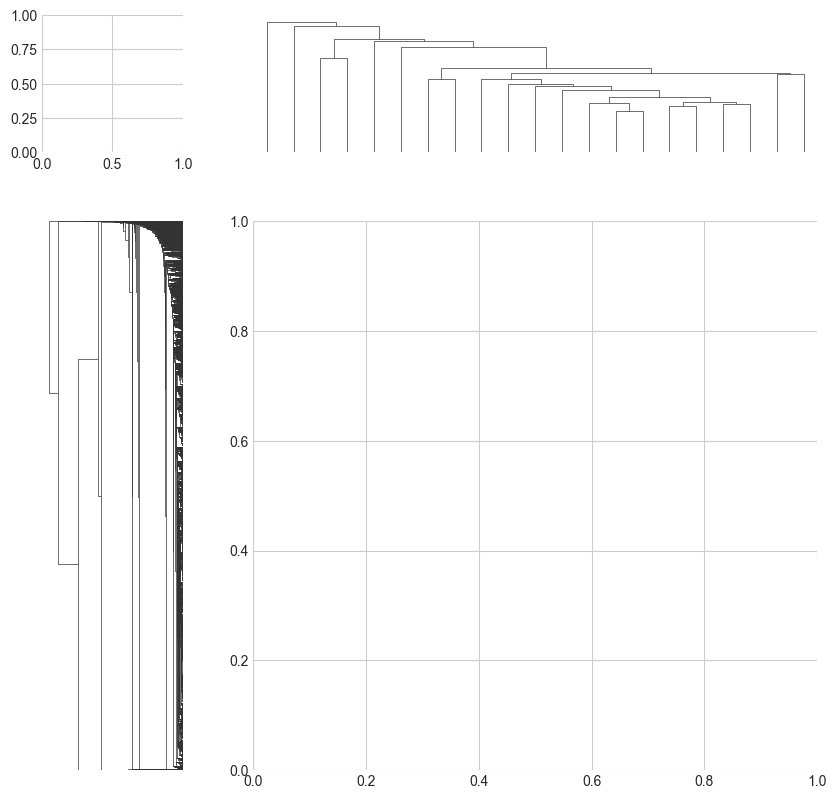

In [111]:
dist=["braycurtis", "canberra", "chebyshev", "cityblock", "correlation", "cosine", "dice", "hamming", "jaccard", "jensenshannon",
      "kulsinski", "kulczynski1", "mahalanobis", "matching", "minkowski", "rogerstanimoto", "russellrao", "seuclidean",
      "sokalmichener", "sokalsneath", "sqeuclidean", "yule"]
sns.clustermap(df,metric="minkowski")

In [35]:
from scipy.spatial.distance import pdist

In [73]:
for i in cdf.columns:
    print(np.sqrt(sum(cdf[i]**2)),i)

97.58425617383547 left ventricle myocardium superior
97.78361551995273 Right ventricle myocardium superior
115.71190489158995 mucosa of descending colon
203.12279377859008 heart left ventricle
124.03906950851939 posterior vena cava
83.36897811044062 left cardiac atrium
193.28806746183065 aorta
223.03306035660177 ovary
116.79241803704343 adrenal gland
119.65499583312992 mesenteric fat pad
147.19437860182086 upper lobe of right lung
208.10258300932077 heart right ventricle
89.94659169444377 left ventricle myocardium inferior
93.3907836011543 left colon
235.85983286070663 right cardiac atrium
147.41808971977972 lower lobe of right lung
190.34706544238918 lower lobe of left lung
89.80272844117862 kidney
115.64300158604134 psoas muscle
39.77155672690341 Right ventricle myocardium inferior
107.19951606872466 cardiac septum


# Part 2: Correcting the log2OR values

In order to improve the results we can find, let us try to compute a better dataframe.

## Computing a better dataframe

In [6]:
def get_contingency(row):
    
    cont=np.zeros((2,2))
    cont[0,0]=row.priA_priB
    cont[1,0]=row.priA_altB
    cont[0,1]=row.altA_priB
    cont[1,1]=row.altA_altB
    
    return cont

In [7]:
def compute_log2OR(row,method="constant",counts=20,corr_dict=None):
    
    cont=np.zeros((2,2))
    cont[0,0]=row.priA_priB
    cont[1,0]=row.priA_altB
    cont[0,1]=row.altA_priB
    cont[1,1]=row.altA_altB
    
    if method == "constant":
        cont+=(counts/4)
        
    if method == "distributed":
        pID=list(r.pID)[0]
        cont+=corr_dict[pID]*counts
    
    res=np.log2((cont[0,0]*cont[1,1])/(cont[1,0]*cont[0,1]))

    return res

In [118]:
r=test["aorta"].iloc[0,:]

In [119]:
a=compute_log2OR(r)
a

-1.1077561803558829

In [156]:
a=get_contingency(r)
a

array([[30., 28.],
       [43., 16.]])

In [8]:
def make_corr_dict(tbl_dict,all_ids=[]):
    
    #retrieve the unique IDS
    if all_ids==[]:
        for k,tab in tbl_dict.items():
            all_ids.extend(list(tab.pID))
        all_ids=list(set(all_ids))
    
    corr_dict={}
    
    error_count=0
    
    for pid in tqdm(all_ids): # for each unique event iterate through the samples on which it happend
        
        conts=[]
        
        for k,tab in tbl_dict.items():
            
            r=tab[tab.pID==pid]
            
            if r.shape[0]!=0:
                
                if r.shape[0]>1:
                    error_count+=1
                    print(f"errors encountered: {error_count}",end="\r")
                    continue
                    
                else:    
                    conts.append(get_contingency(r))
        if conts==[]:
            continue
        s=sum(conts)+1
        d1=s/s.sum()
        corr_dict[pid]=d1
    
    return corr_dict
    

In [9]:
def make_cluster_df(tbl_dict,method="constant",counts=20,corr_dict=None,all_ids=[]):
    
    #retrieve the unique IDS
    if all_ids==[]:
        for k,tab in tbl_dict.items():
            all_ids.extend(list(tab.pID))
        all_ids=list(set(all_ids))
    
    data={k:[] for k in tbl_dict.keys()}
    
    error_count=0
        
    i=0
    for pid in tqdm(all_ids):
        for k,tab in tbl_dict.items():
            
            r=tab[tab.pID==pid]
            if r.shape[0]!=0:
                
                if r.shape[0]>1:
                    error_count+=1
                    print(f"errors encountered: {error_count}",end="\r")
                    data[k].append(pd.NA)
                    
                else:    
                    #data[k].append(float(r.log2OR))
                    
                    data[k].append(compute_log2OR(r,method=method,counts=counts,corr_dict=corr_dict))
            
            else:
                #try:
                 #   corr_m=corr_dict[pid]*counts
                  #  log_or=np.log2(corr_m[0,0]*corr_m[1,1])/(corr_m[1,0]*corr_m[0,1])
                   # data[k].append(log_or)
                #except KeyError:
                data[k].append(0.0)

    df=pd.DataFrame(data,index=all_ids)
    nrow=df.shape[0]
    df=df.dropna()
    print(f"number of rows dropped: {nrow-df.shape[0]}")
    df=df.astype("float64")
    
    return df

### In how many samples do unique events usually tend to happen?

In [188]:
def get_counts(tbl_dict):
    
    #retrieve the unique IDS
    all_ids=[]
    for k,tab in tbl_dict.items():
        all_ids.extend(list(tab.pID))
    all_ids=list(set(all_ids))
    
    count_dict={}
    
    error_count=0
    
    for pid in tqdm(all_ids): # for each unique event iterate through the samples on which it happend
        
        conts=[]
        
        for k,tab in tbl_dict.items():
            
            r=tab[tab.pID==pid]
            
            if r.shape[0]!=0:
                
                if r.shape[0]>1:
                    error_count+=1
                    print(f"errors encountered: {error_count}",end="\r")
                    continue
                    
                else:    
                    conts.append(get_contingency(r))
        if conts==[]:
            continue
            
        count_dict[pid]=len(conts)
    
    return count_dict

In [191]:
counts=get_counts(tissue_dict)

  0%|          | 0/27878 [00:00<?, ?it/s]

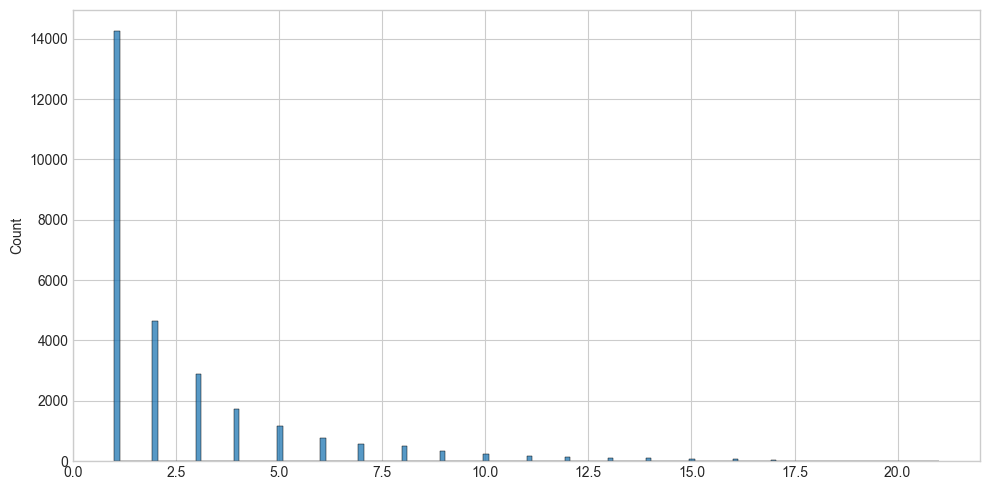

In [201]:
fig,ax=plt.subplots(figsize=(10,5))

sns.histplot(list(counts.values()),ax=ax)

fig.tight_layout()

### Test

In [112]:
test={k:tab.head(n=100) for k,tab in tissue_dict.items()}

  0%|          | 0/1051 [00:00<?, ?it/s]

number of rows dropped: 2


In [184]:
l=make_corr_dict(test)
l["PAS:TSS:41754603:41755432:41769417:41769683"]

  0%|          | 0/1051 [00:00<?, ?it/s]

array([[0.20224719, 0.43258427],
       [0.13483146, 0.23033708]])

In [139]:
df=make_cluster_df(test)

  0%|          | 0/1051 [00:00<?, ?it/s]

number of rows dropped: 2


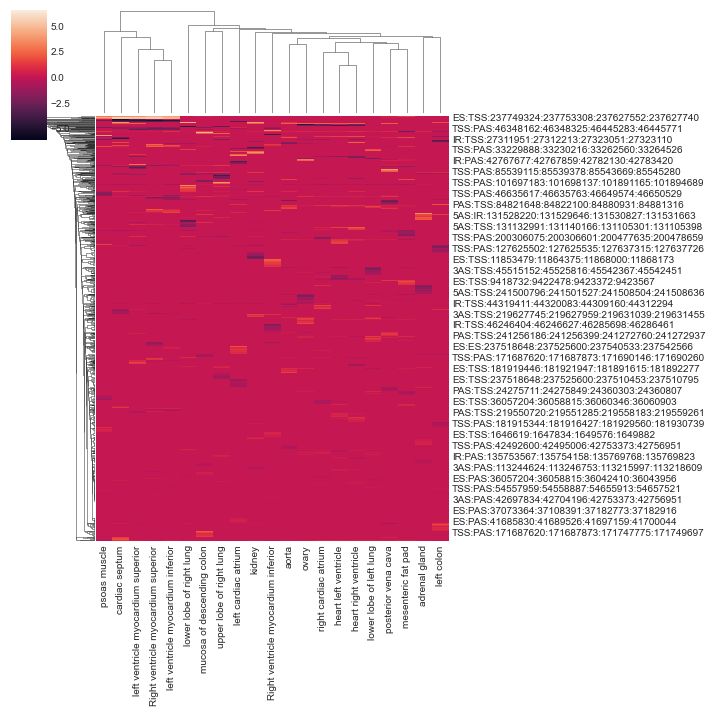

In [136]:
sns.clustermap(df)

In [140]:
dfs={c:make_cluster_df(test,constant=c) for c in range(1,11)}

  0%|          | 0/1051 [00:00<?, ?it/s]

number of rows dropped: 2


  0%|          | 0/1051 [00:00<?, ?it/s]

number of rows dropped: 2


  0%|          | 0/1051 [00:00<?, ?it/s]

number of rows dropped: 2


  0%|          | 0/1051 [00:00<?, ?it/s]

number of rows dropped: 2


  0%|          | 0/1051 [00:00<?, ?it/s]

number of rows dropped: 2


  0%|          | 0/1051 [00:00<?, ?it/s]

number of rows dropped: 2


  0%|          | 0/1051 [00:00<?, ?it/s]

number of rows dropped: 2


  0%|          | 0/1051 [00:00<?, ?it/s]

number of rows dropped: 2


  0%|          | 0/1051 [00:00<?, ?it/s]

number of rows dropped: 2


  0%|          | 0/1051 [00:00<?, ?it/s]

number of rows dropped: 2


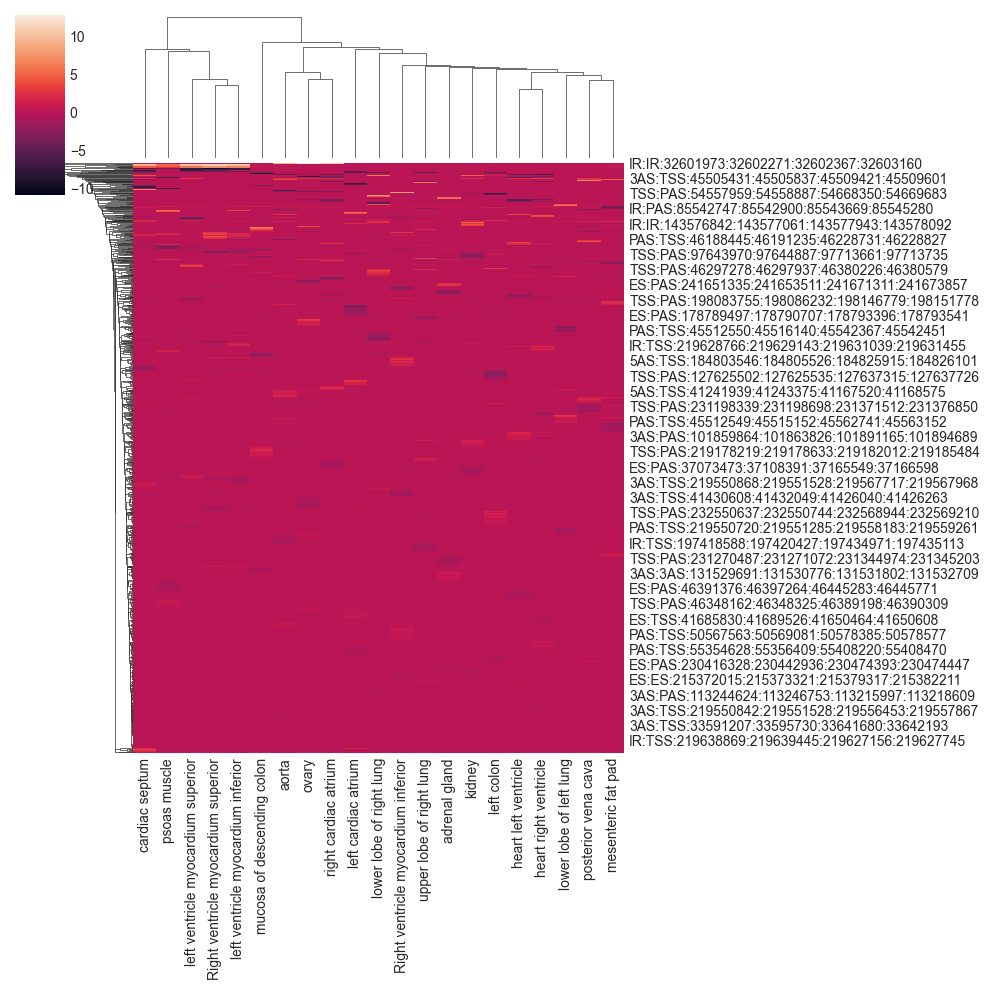

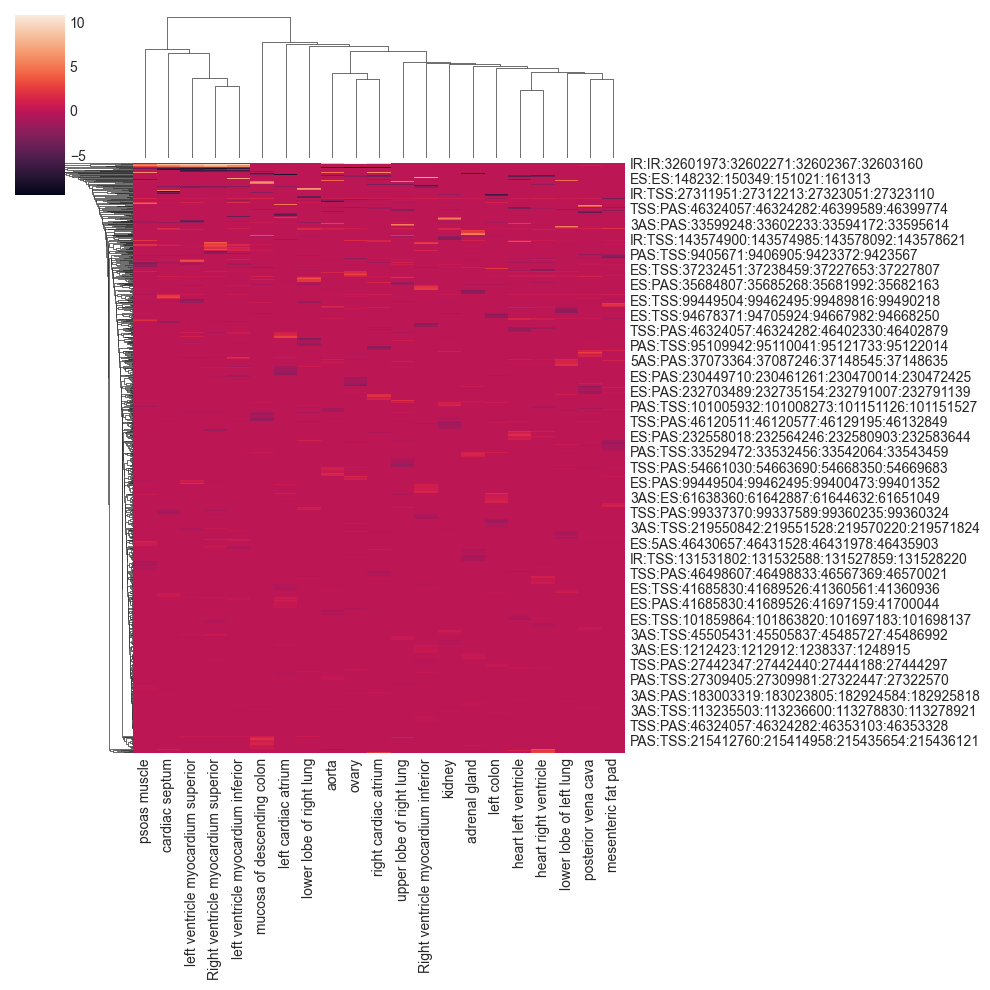

In [240]:
for c in range(1,3):
    sns.clustermap(dfs[c])

In [267]:
df=make_cluster_df(tissue_dict,method="distributed",counts=5*4,corr_dict=corr_dict)

  0%|          | 0/27878 [00:00<?, ?it/s]

number of rows dropped: 66


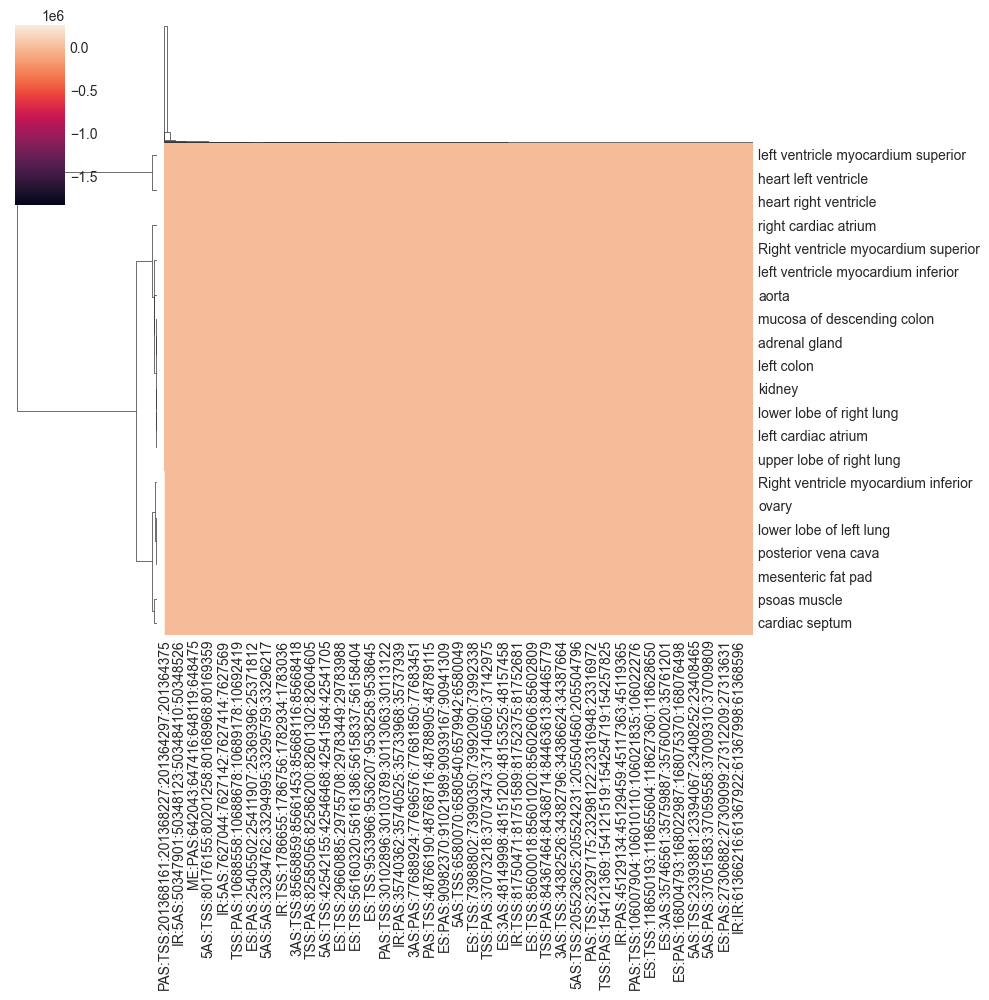

In [270]:
sns.clustermap(df.transpose())

<AxesSubplot:xlabel='aorta', ylabel='Density'>

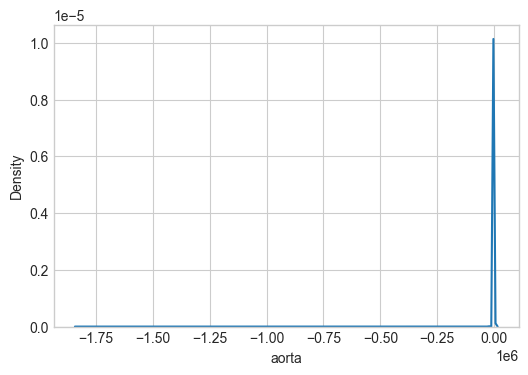

In [273]:
sns.kdeplot(df["aorta"])

### Computing the dataframes with constant corrections

In [153]:
tabl_path="/project/hfa_work/ceraolo/theco/tables/clustering/"
files=[x.name for x in Path(tabl_path).iterdir()]

const_dfs={}

for c in range(1,21):
    fname=f"constant{c}_or.csv"
    if fname not in files:
        print(f"comp uting {fname}")
        const_dfs[c]=make_cluster_df(tissue_dict,method="constant",constant=c)
        const_dfs[c].to_csv(tabl_path+fname,index=False)
    else:
        print(f"reading {fname}")
        const_dfs[c]=pd.read_csv(tabl_path+fname)

reading constant1_or.csv
reading constant2_or.csv
reading constant3_or.csv
reading constant4_or.csv
reading constant5_or.csv
reading constant6_or.csv
reading constant7_or.csv
reading constant8_or.csv
reading constant9_or.csv
reading constant10_or.csv
reading constant11_or.csv
reading constant12_or.csv
reading constant13_or.csv
reading constant14_or.csv
reading constant15_or.csv
reading constant16_or.csv
reading constant17_or.csv
reading constant18_or.csv
reading constant19_or.csv
reading constant20_or.csv


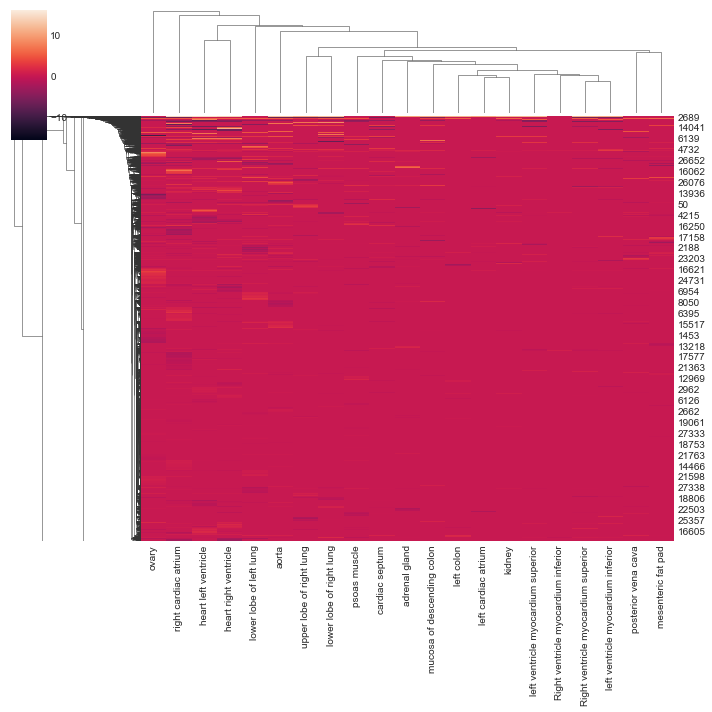

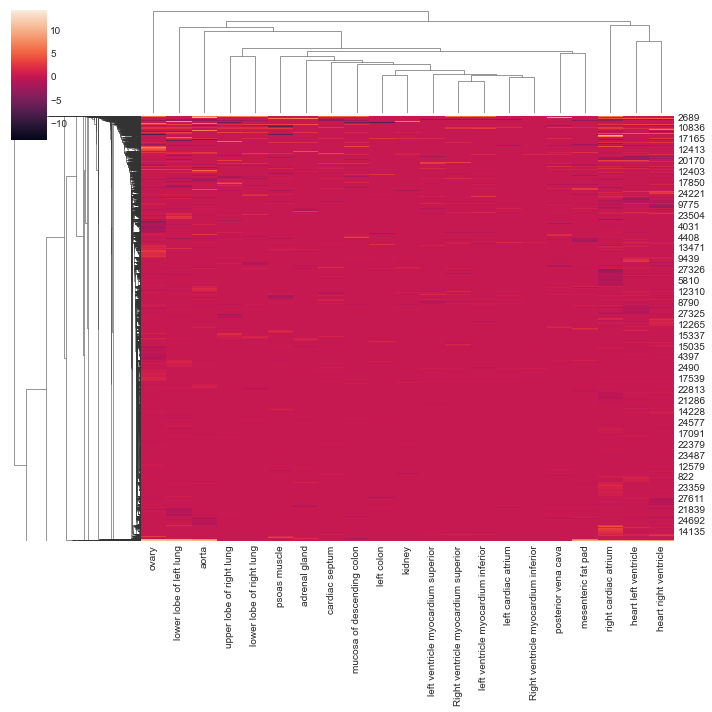

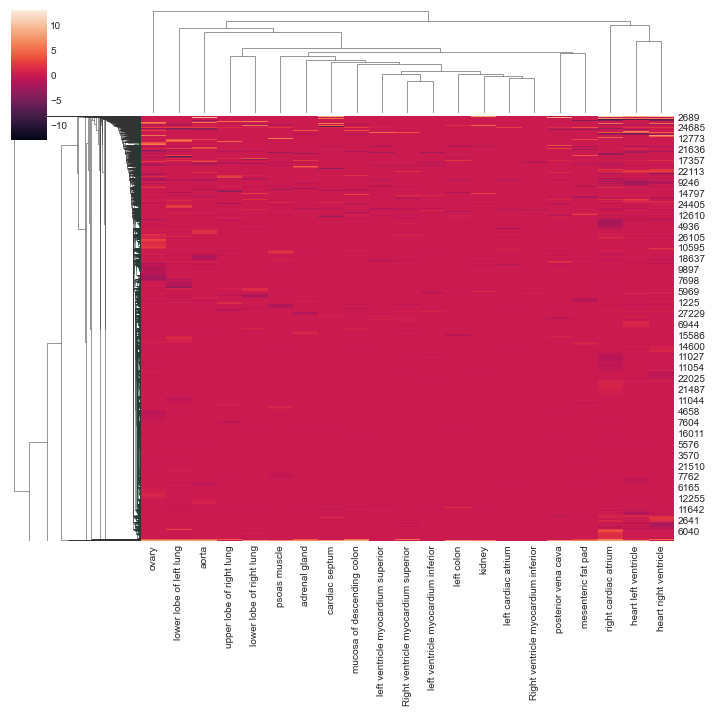

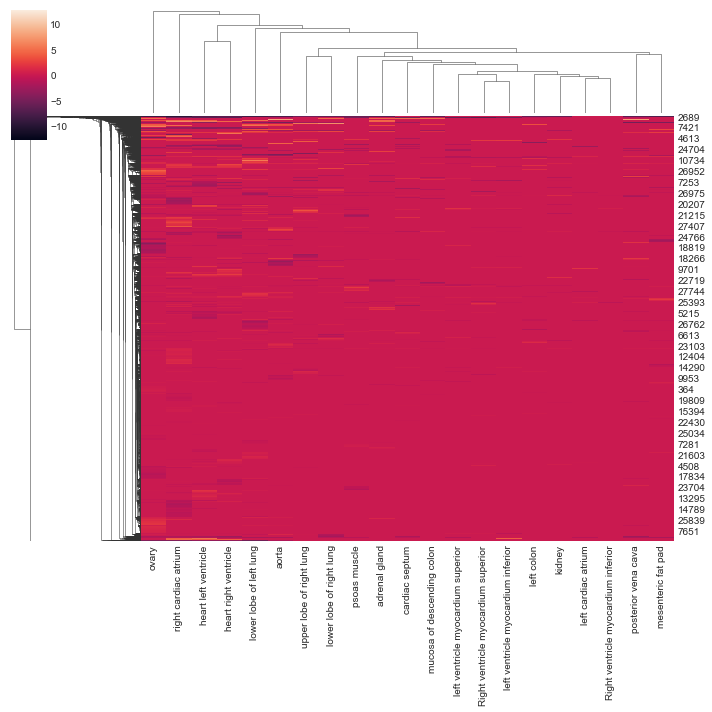

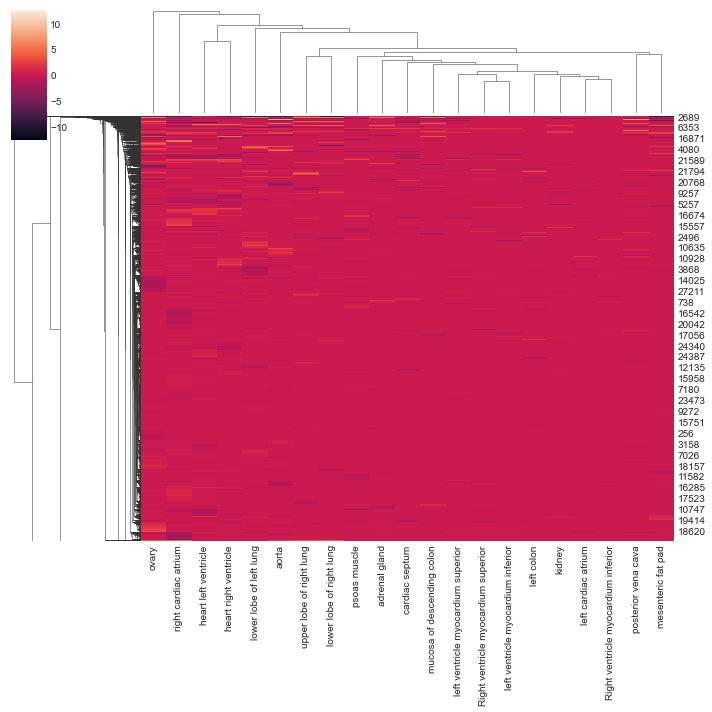

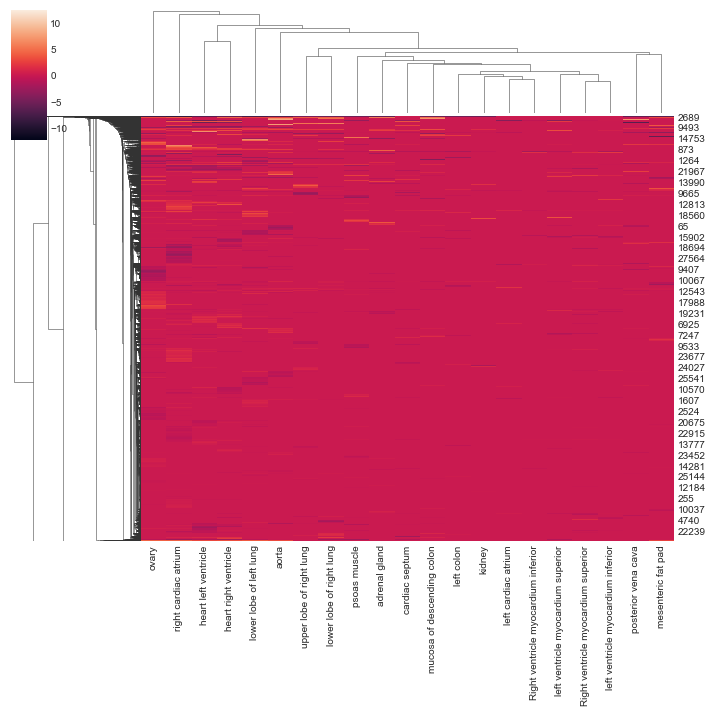

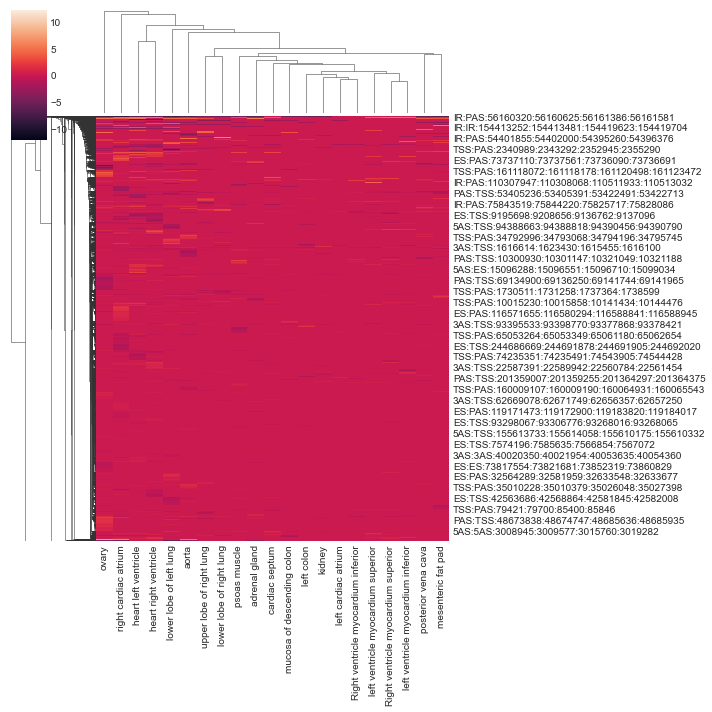

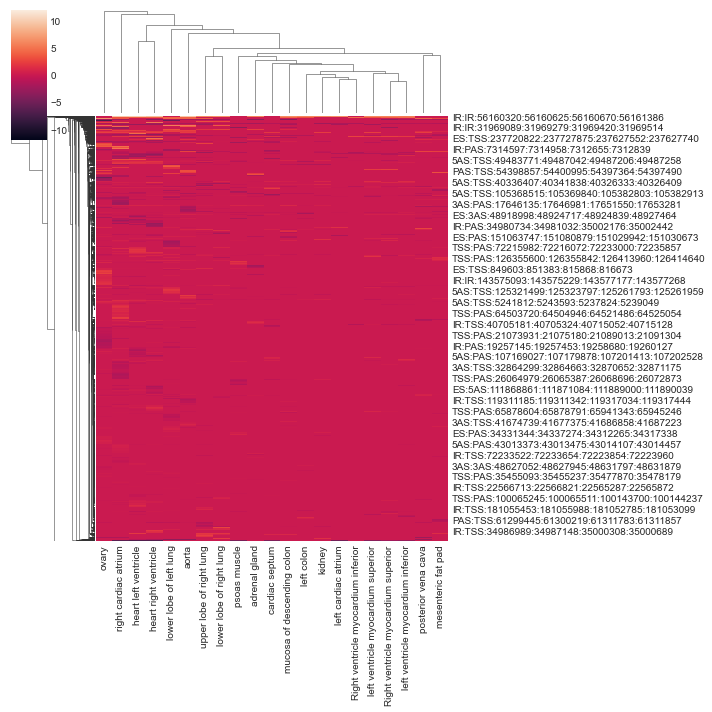

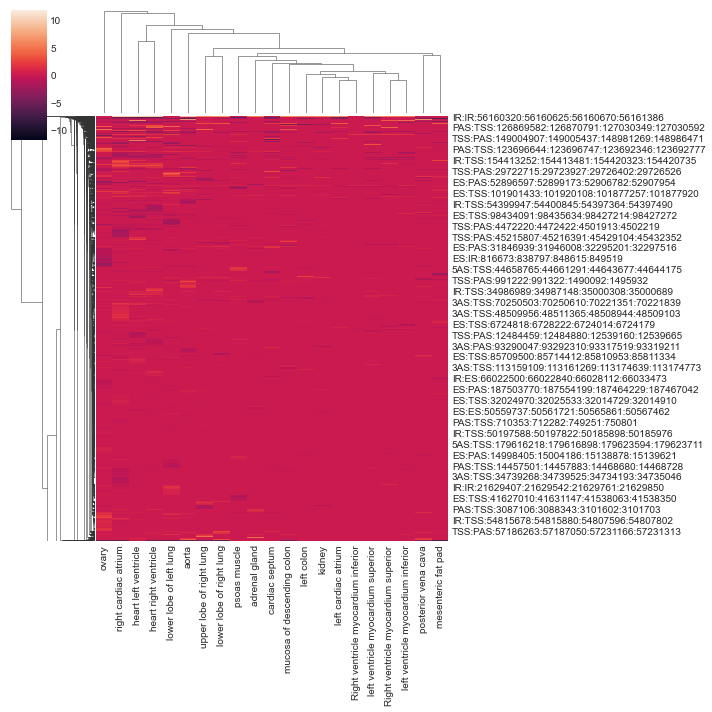

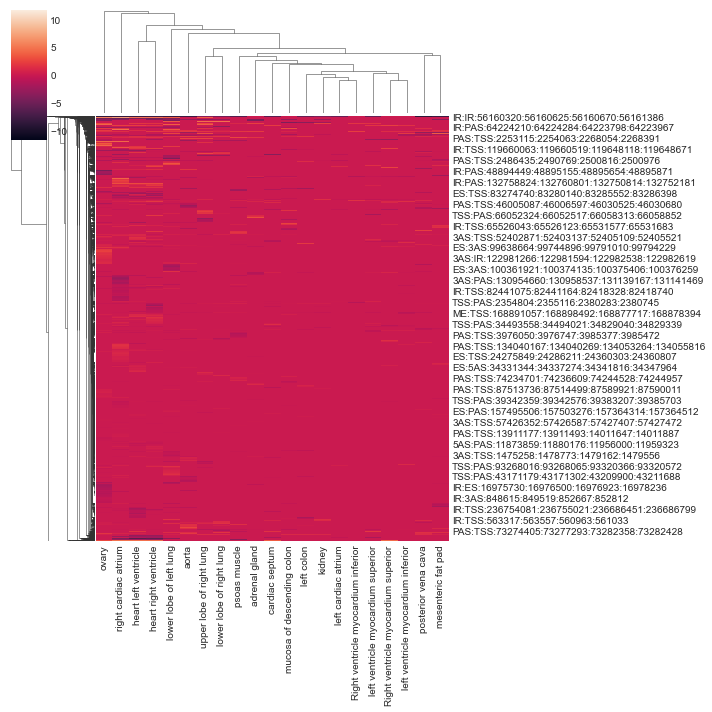

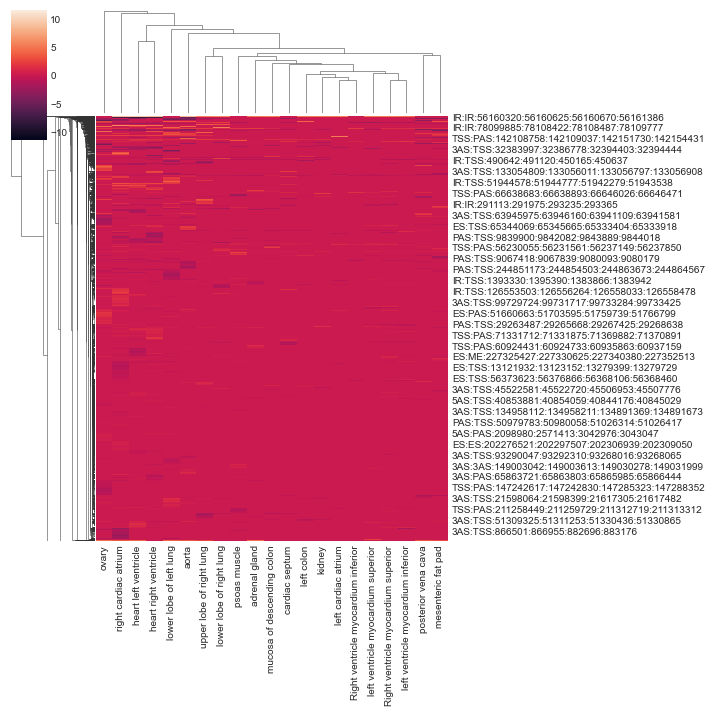

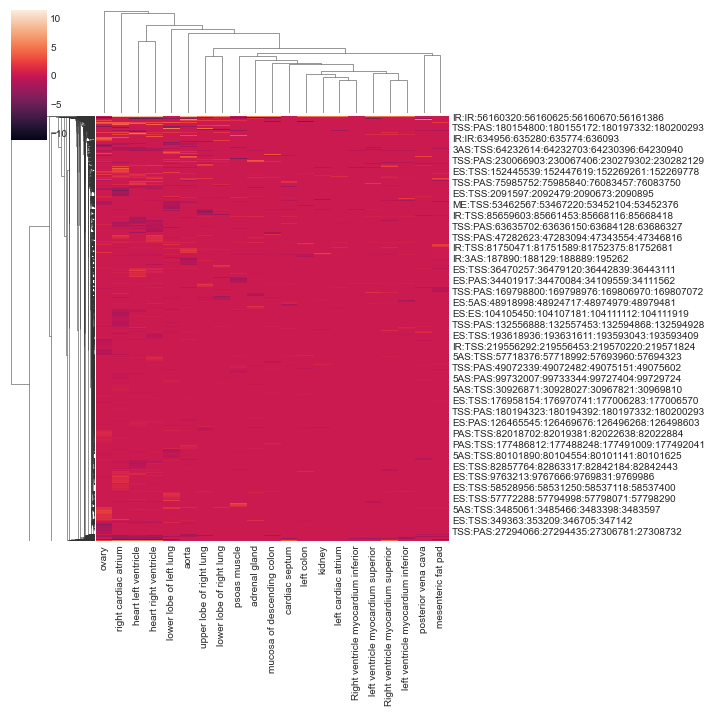

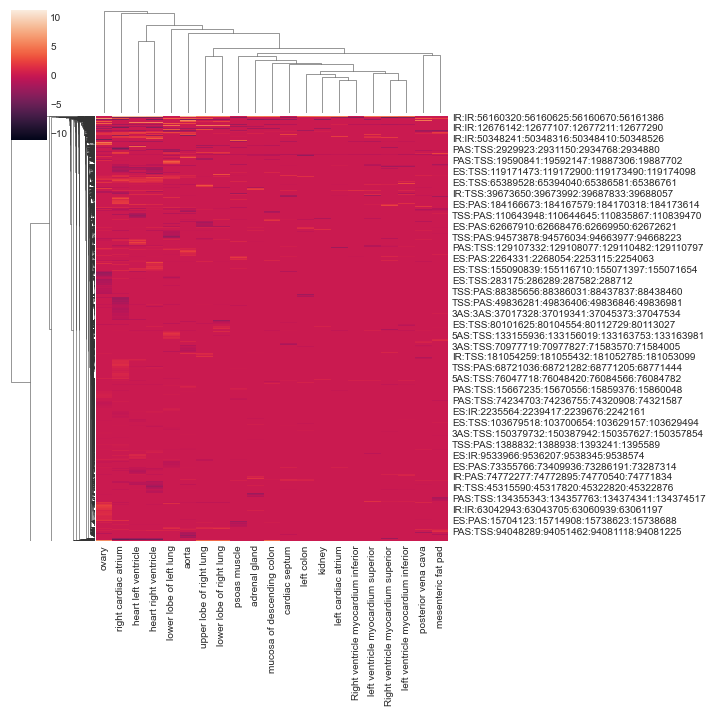

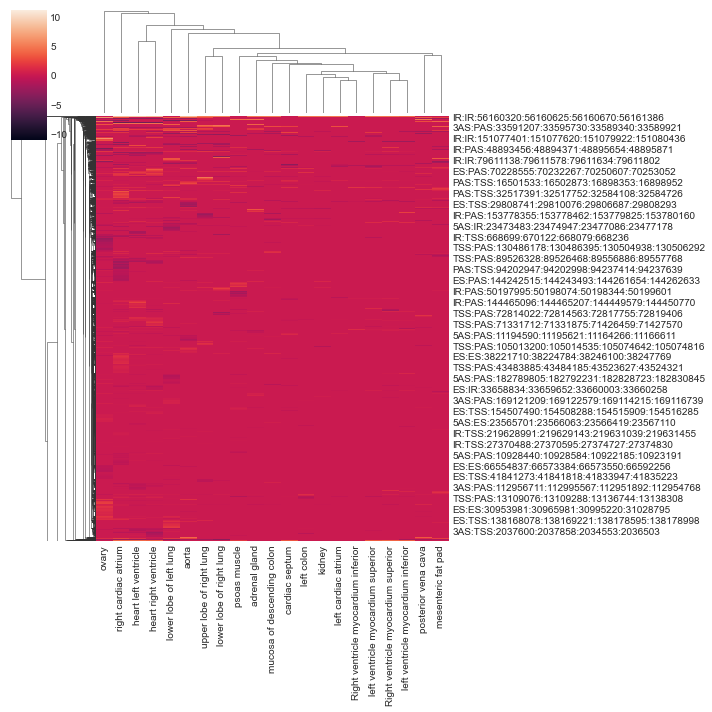

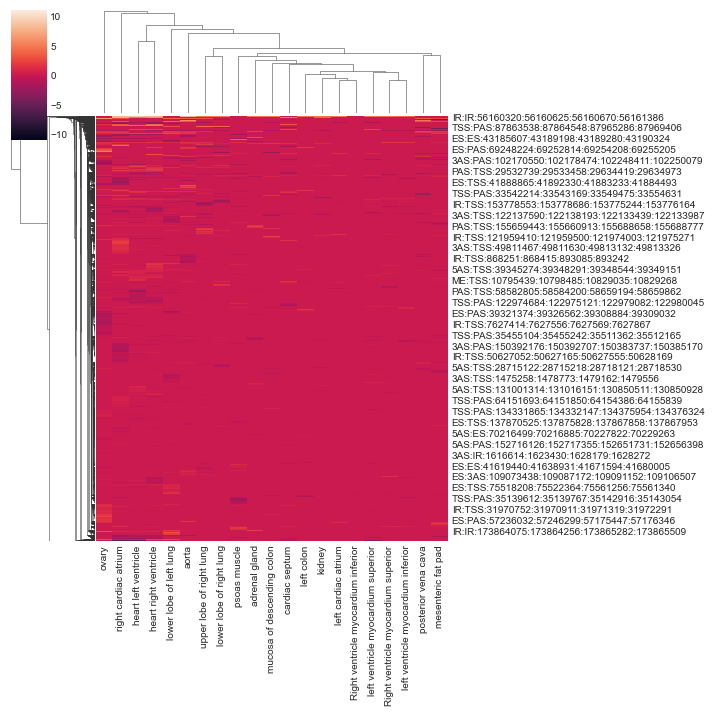

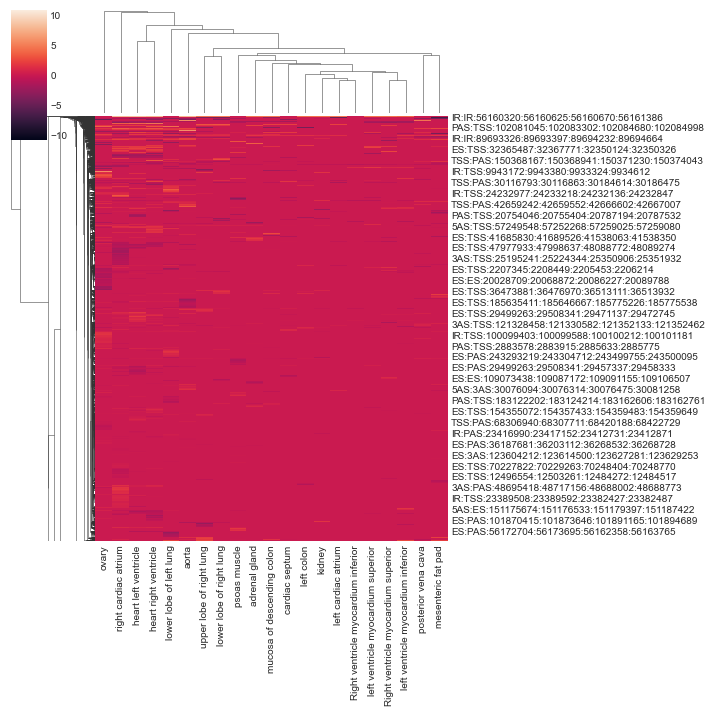

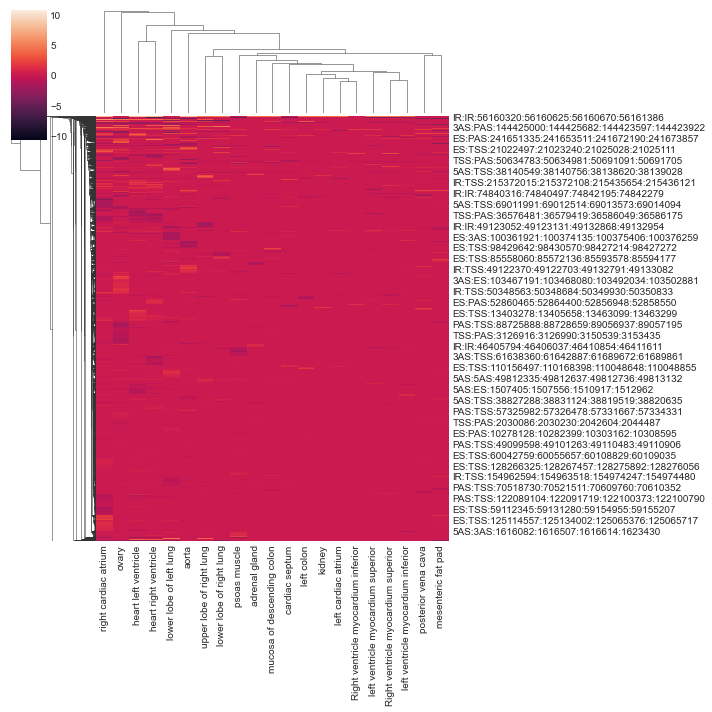

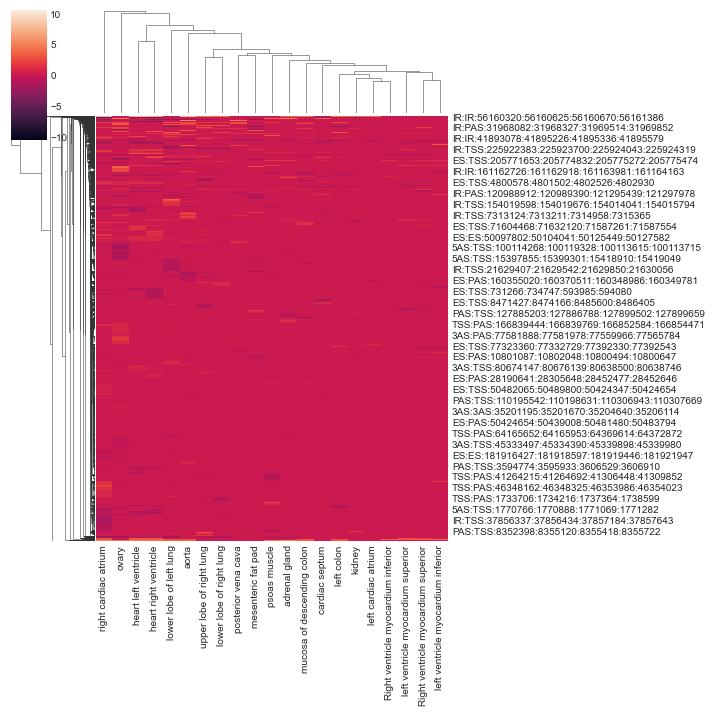

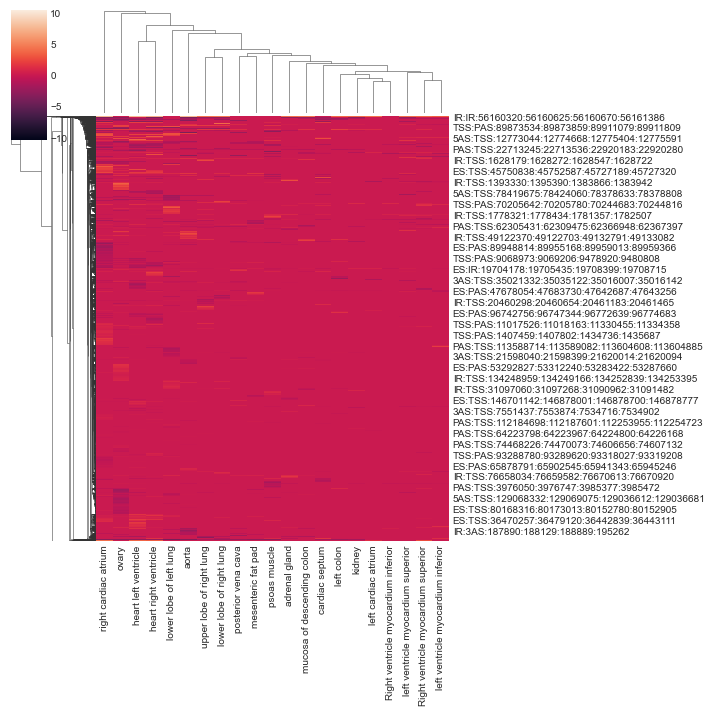

In [150]:
for c in range(1,21):
    sns.clustermap(const_dfs[c])

### Computing the dataframes with distributed corrections

In [263]:
corr_dict=make_corr_dict(tissue_dict)

  0%|          | 0/27878 [00:00<?, ?it/s]

In [238]:
tabl_path="/project/hfa_work/ceraolo/theco/tables/clustering/"
files=[x.name for x in Path(tabl_path).iterdir()]

dist_dfs={}

for c in range(1,21):
    fname=f"distributed{c}_or.csv"
    if fname not in files:
        print(f"computing {fname}")
        dist_dfs[c]=make_cluster_df(tissue_dict,method="distributed",counts=c*4,corr_dict=corr_dict)
        dist_dfs[c].to_csv(tabl_path+fname,index=False)
    else:
        print(f"reading {fname}")
        dist_dfs[c]=pd.read_csv(tabl_path+fname)

reading distributed1_or.csv
reading distributed2_or.csv
reading distributed3_or.csv
reading distributed4_or.csv
reading distributed5_or.csv
reading distributed6_or.csv
reading distributed7_or.csv
reading distributed8_or.csv
reading distributed9_or.csv
reading distributed10_or.csv
reading distributed11_or.csv
reading distributed12_or.csv
reading distributed13_or.csv
reading distributed14_or.csv
reading distributed15_or.csv
reading distributed16_or.csv
reading distributed17_or.csv
reading distributed18_or.csv
reading distributed19_or.csv
reading distributed20_or.csv


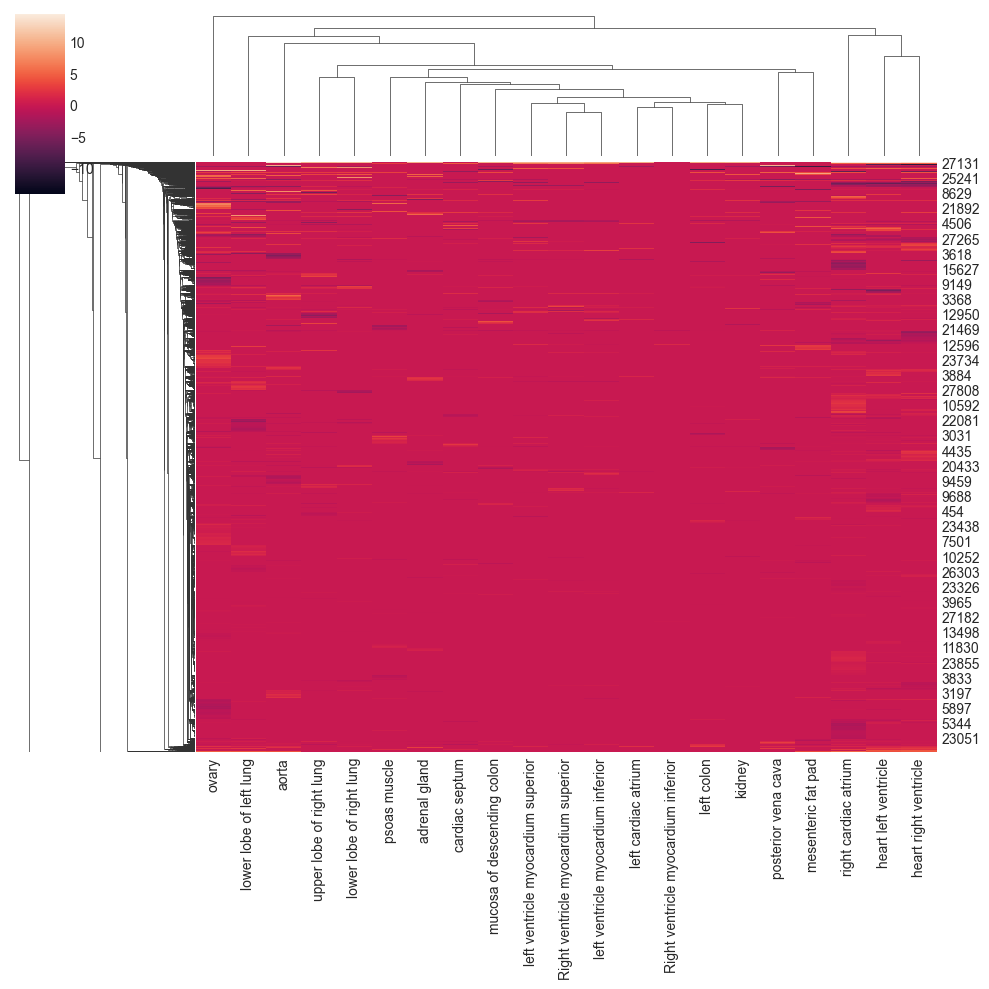

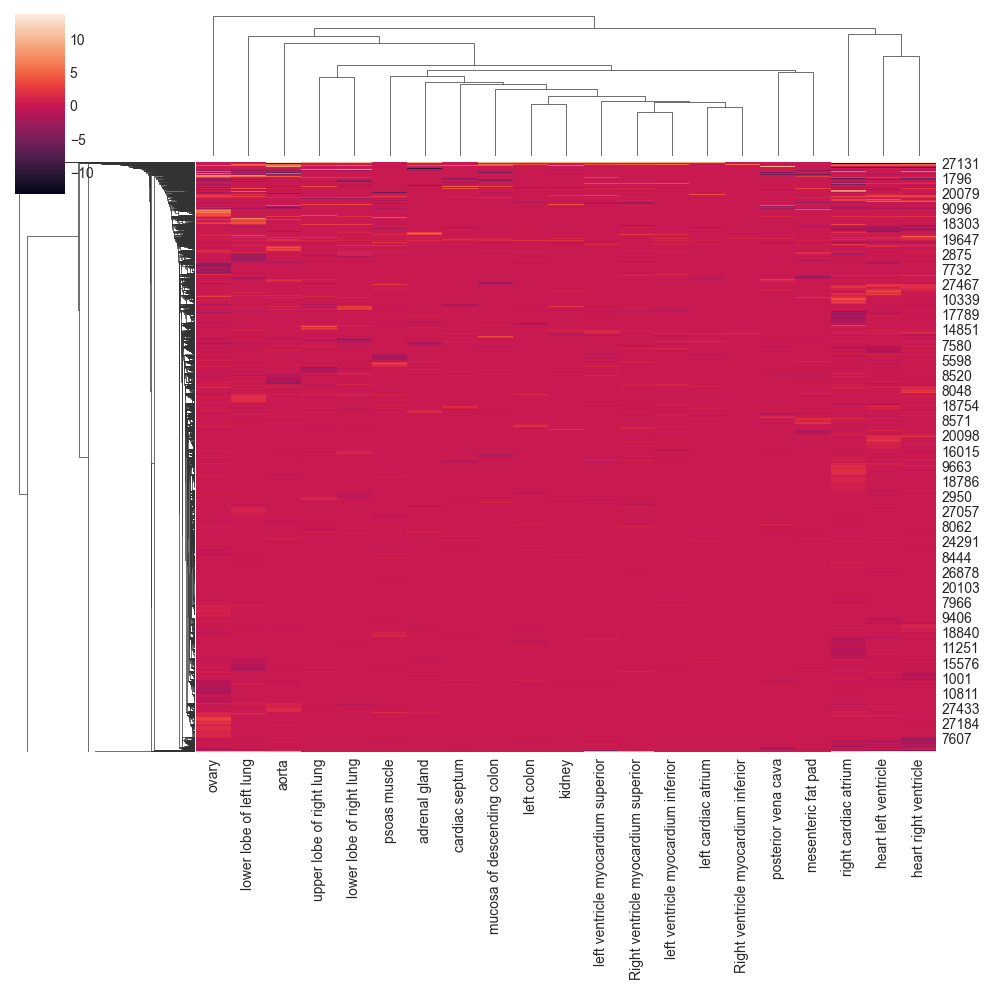

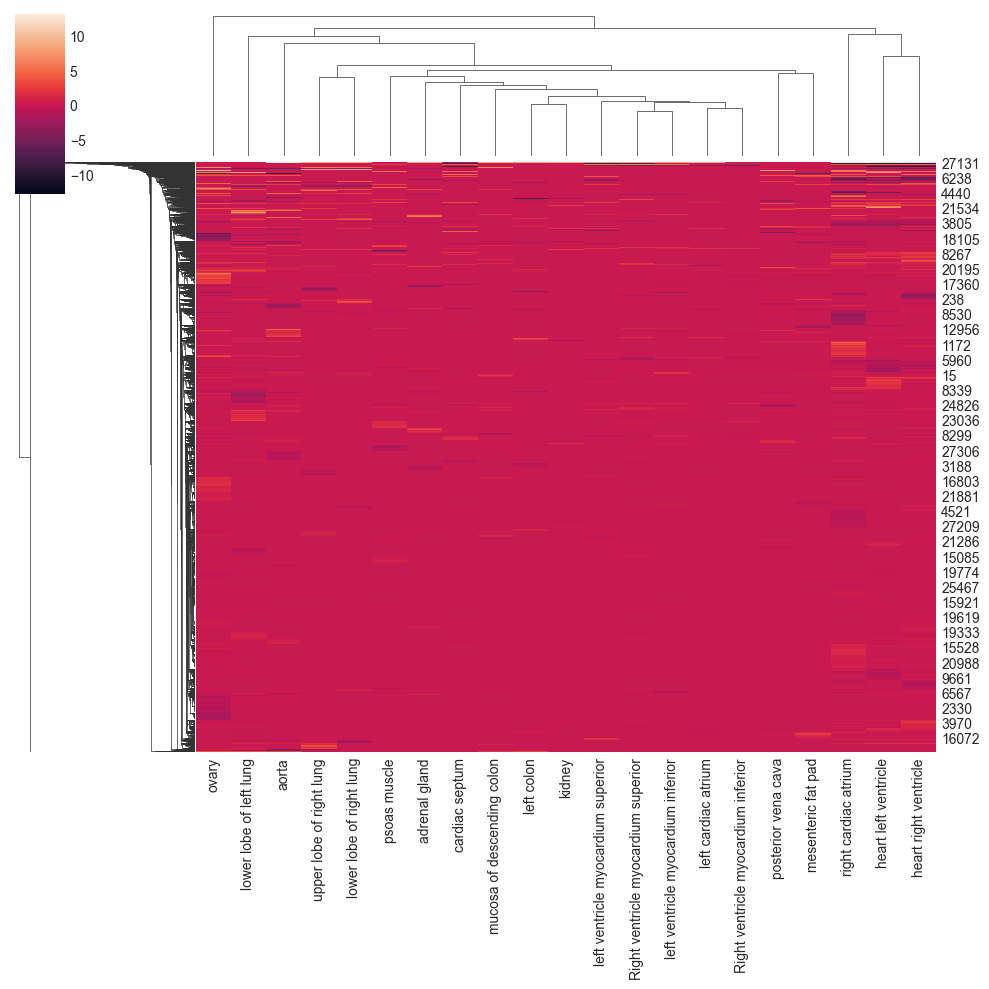

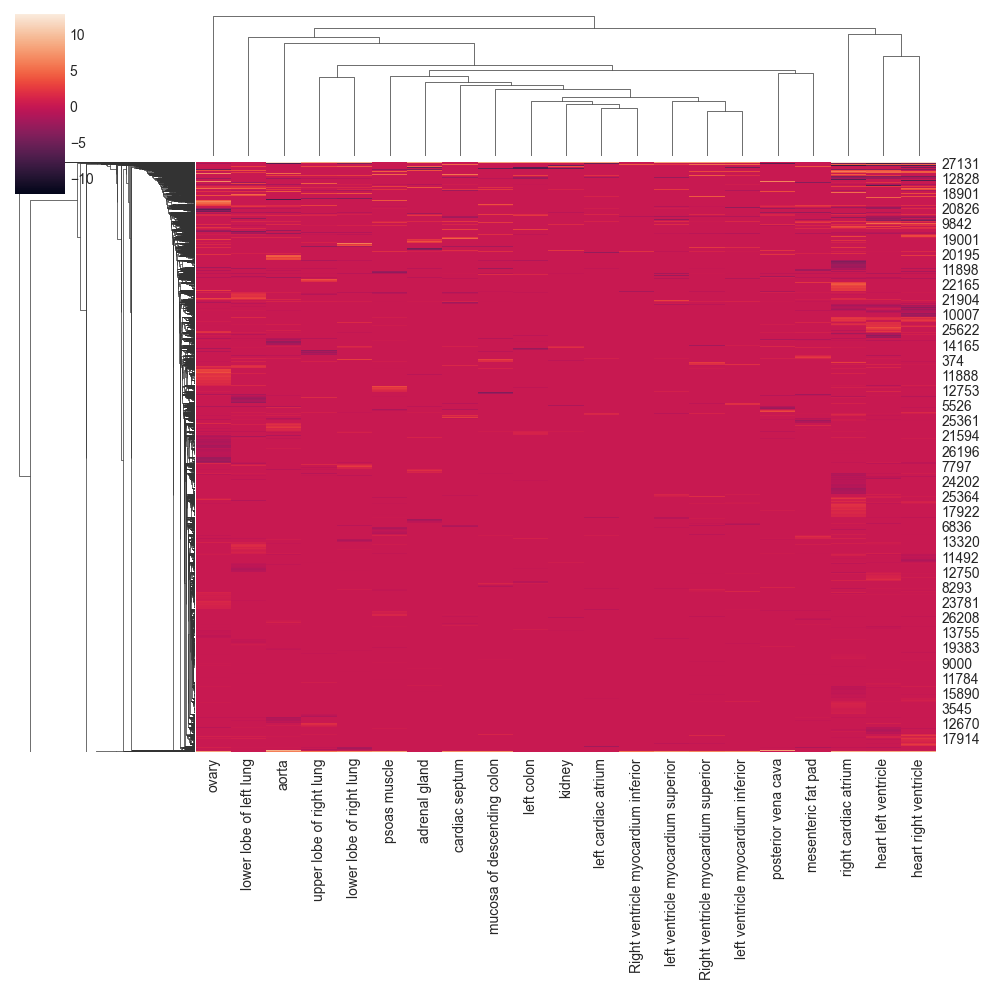

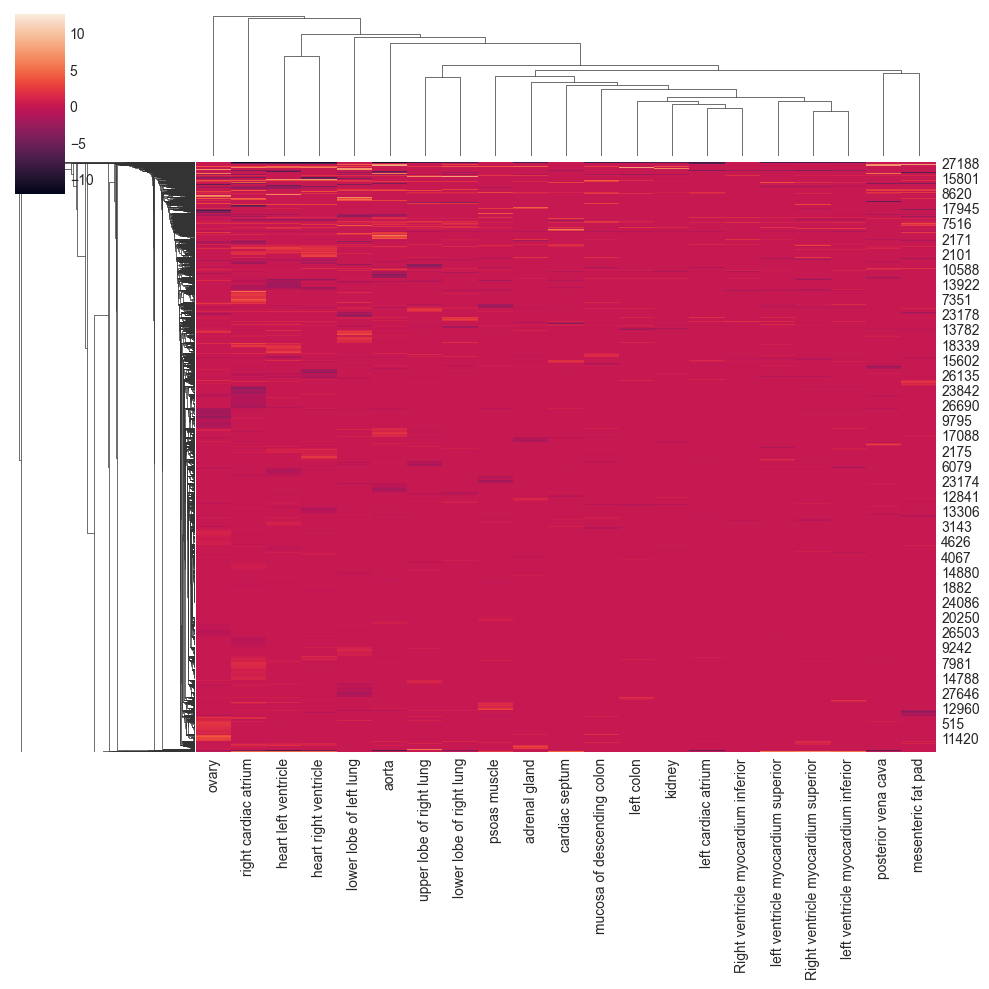

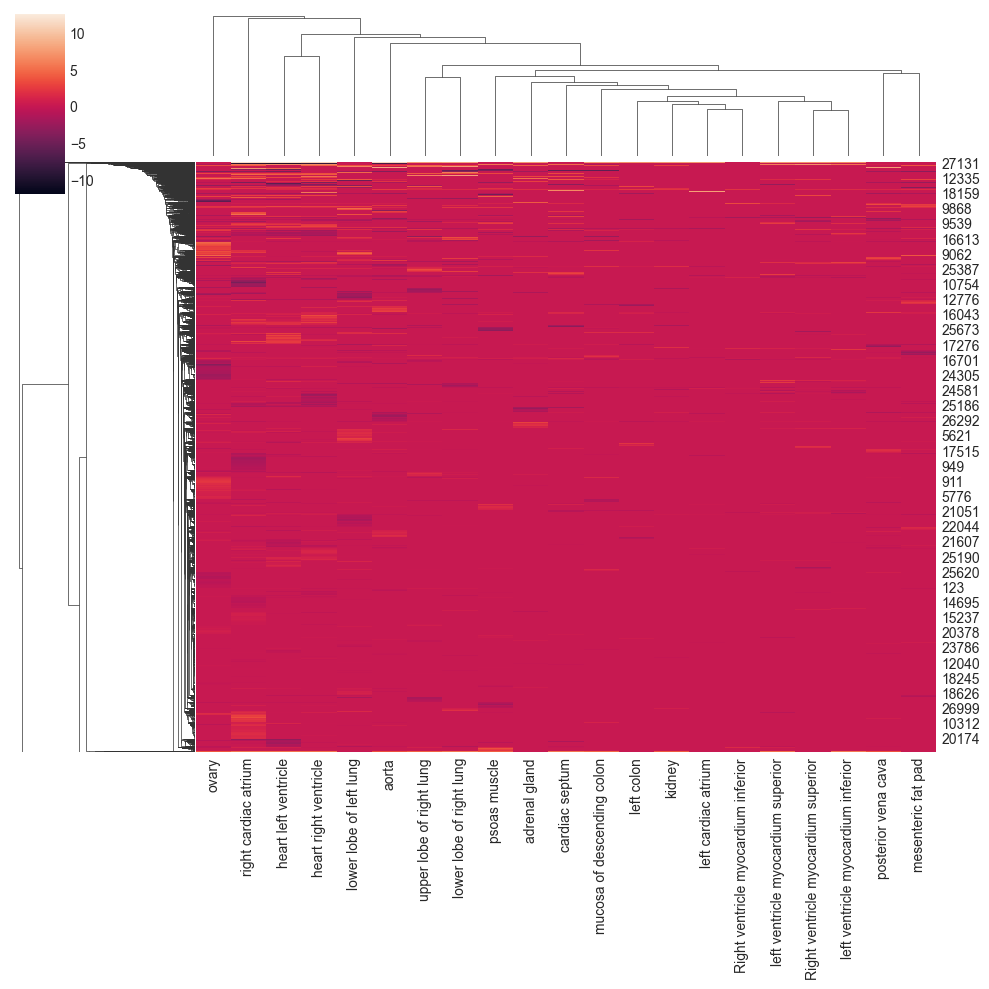

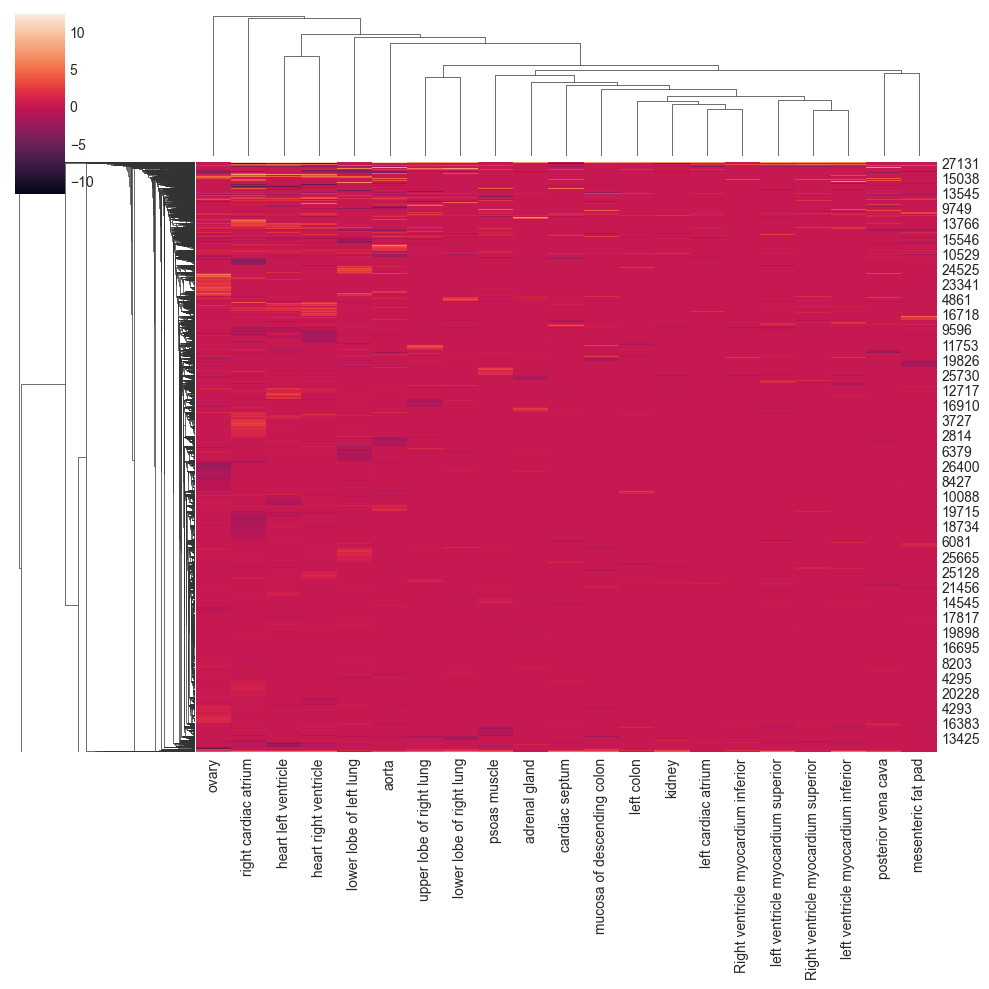

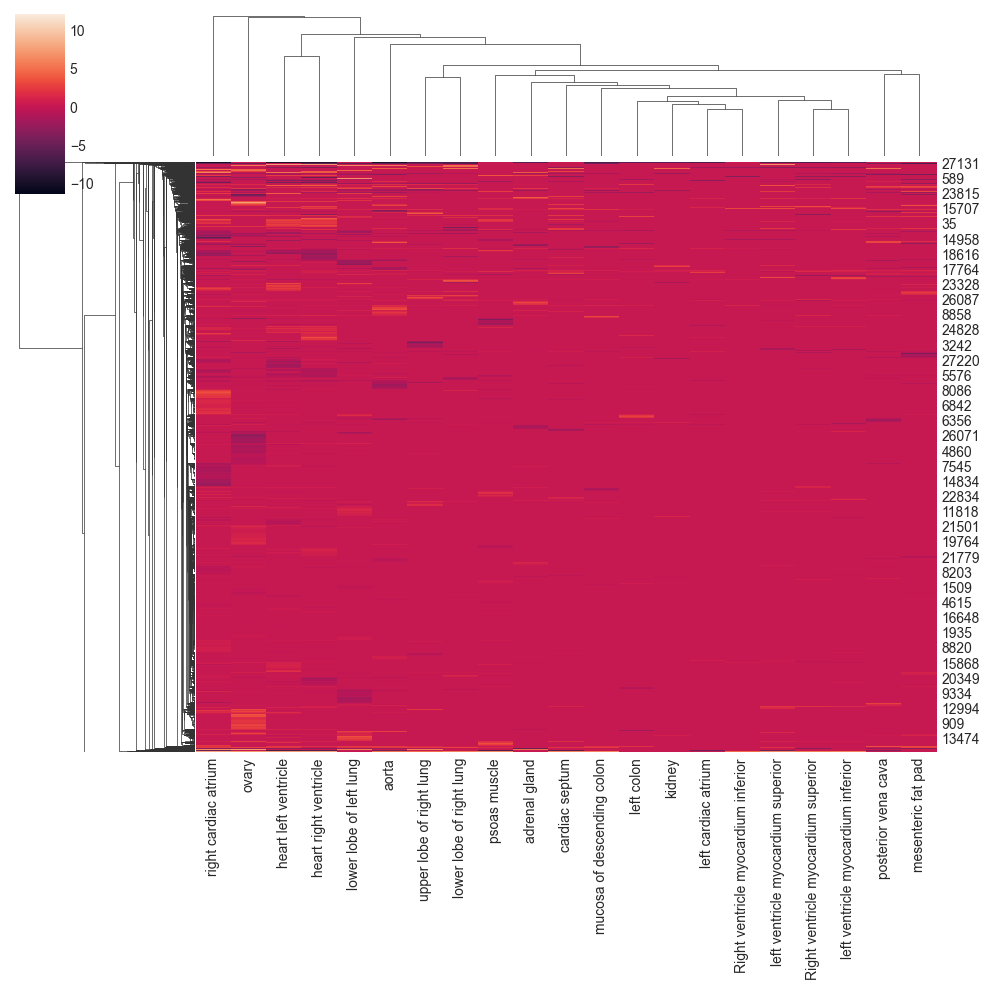

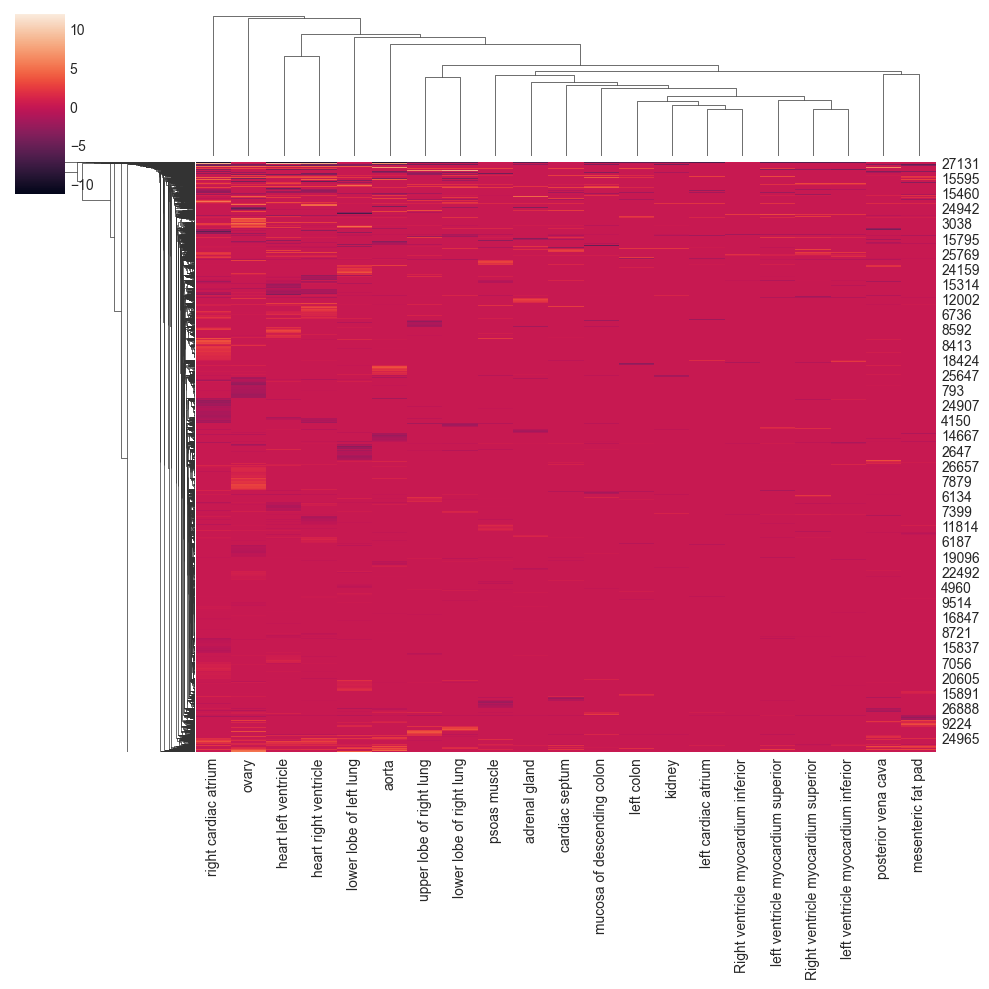

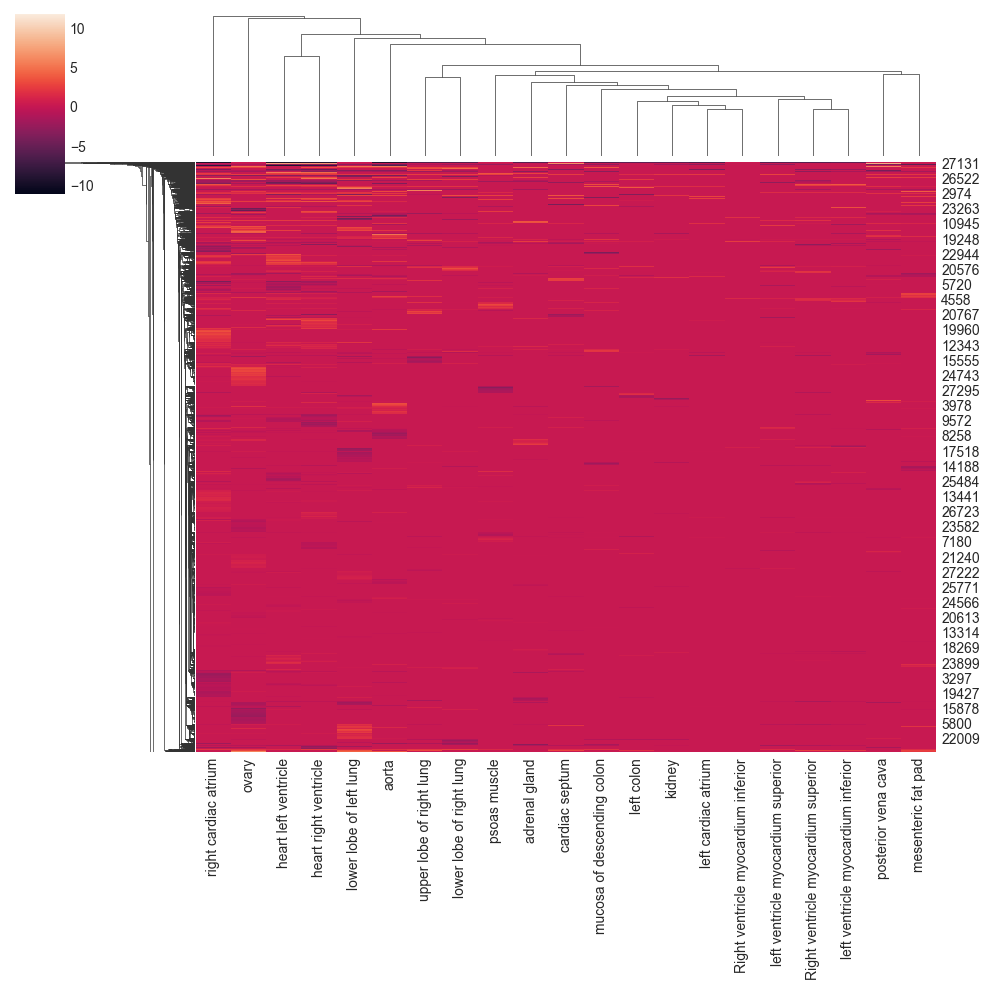

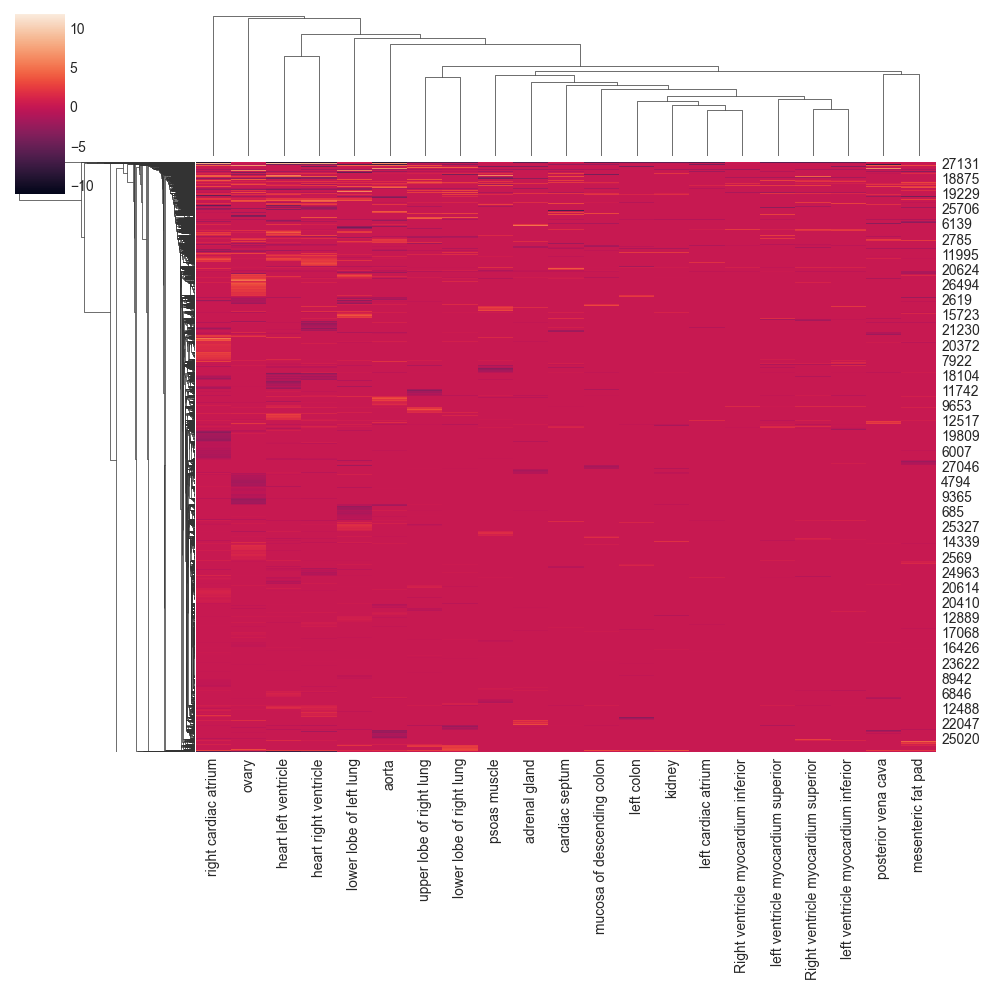

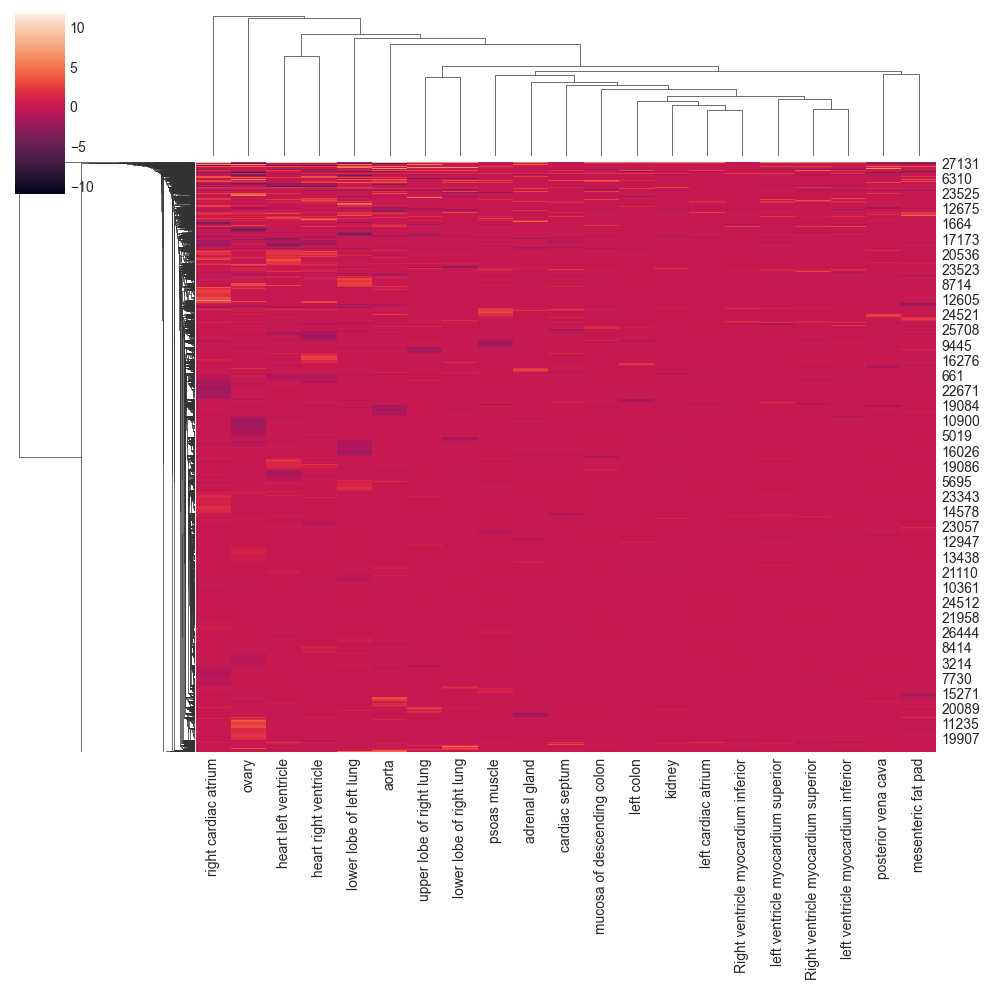

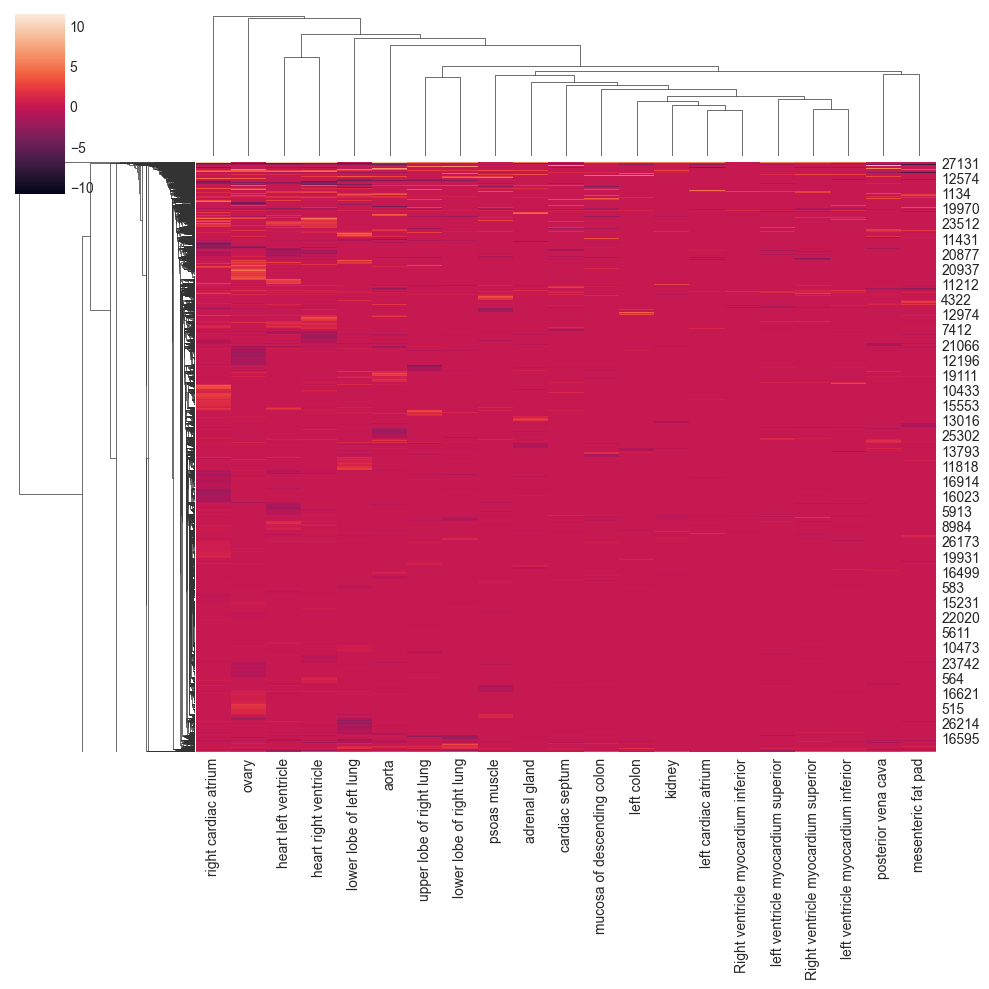

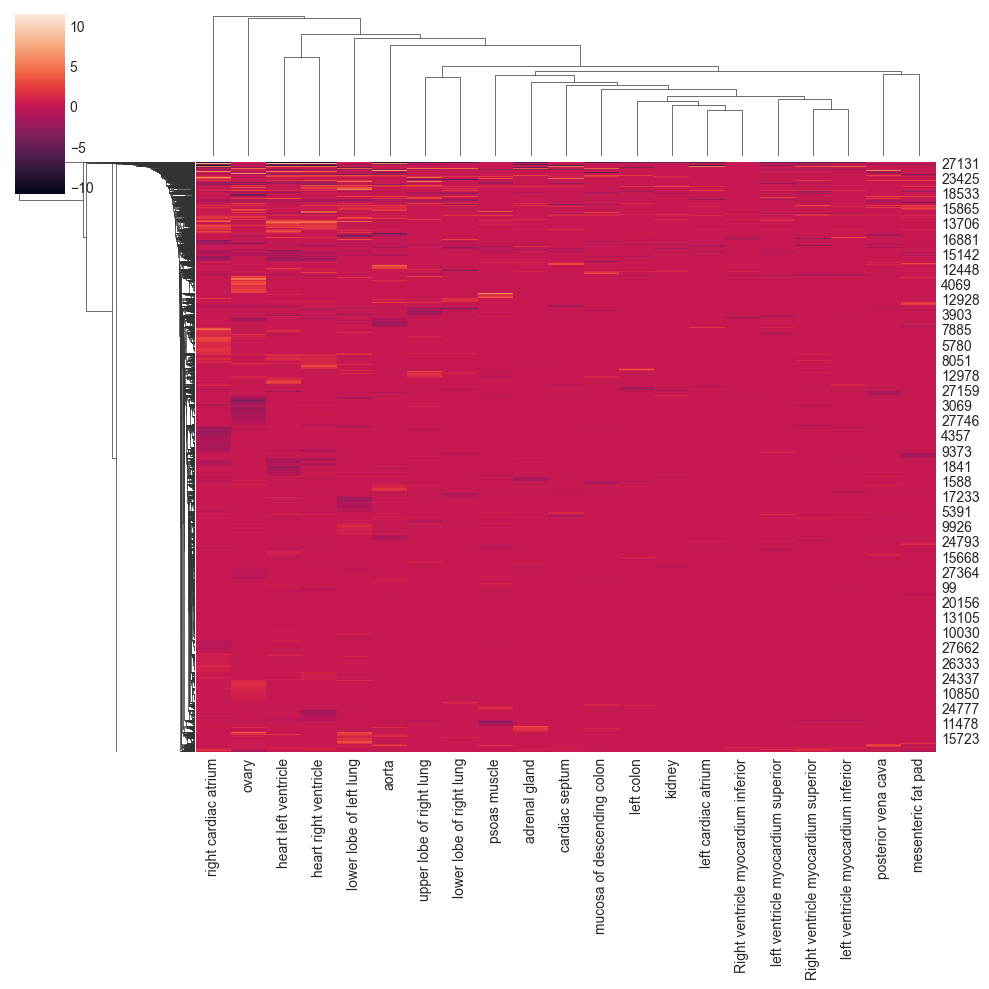

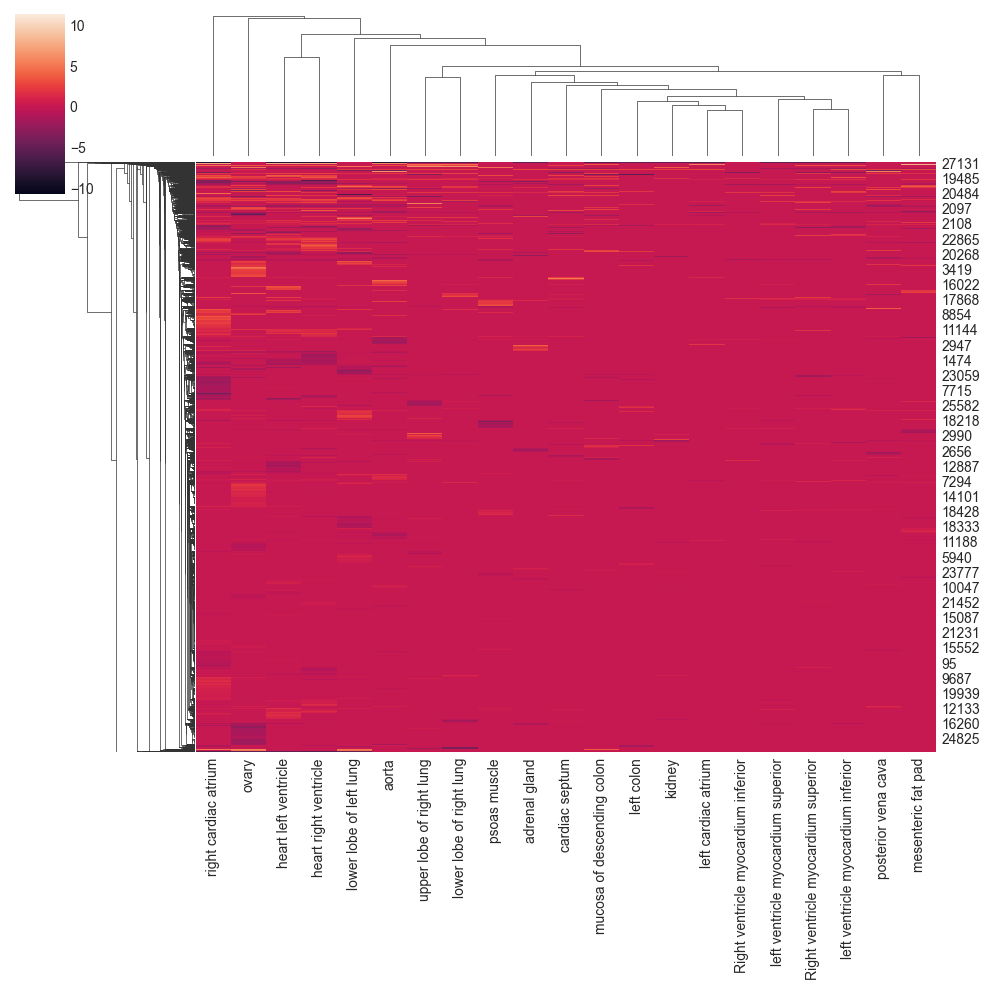

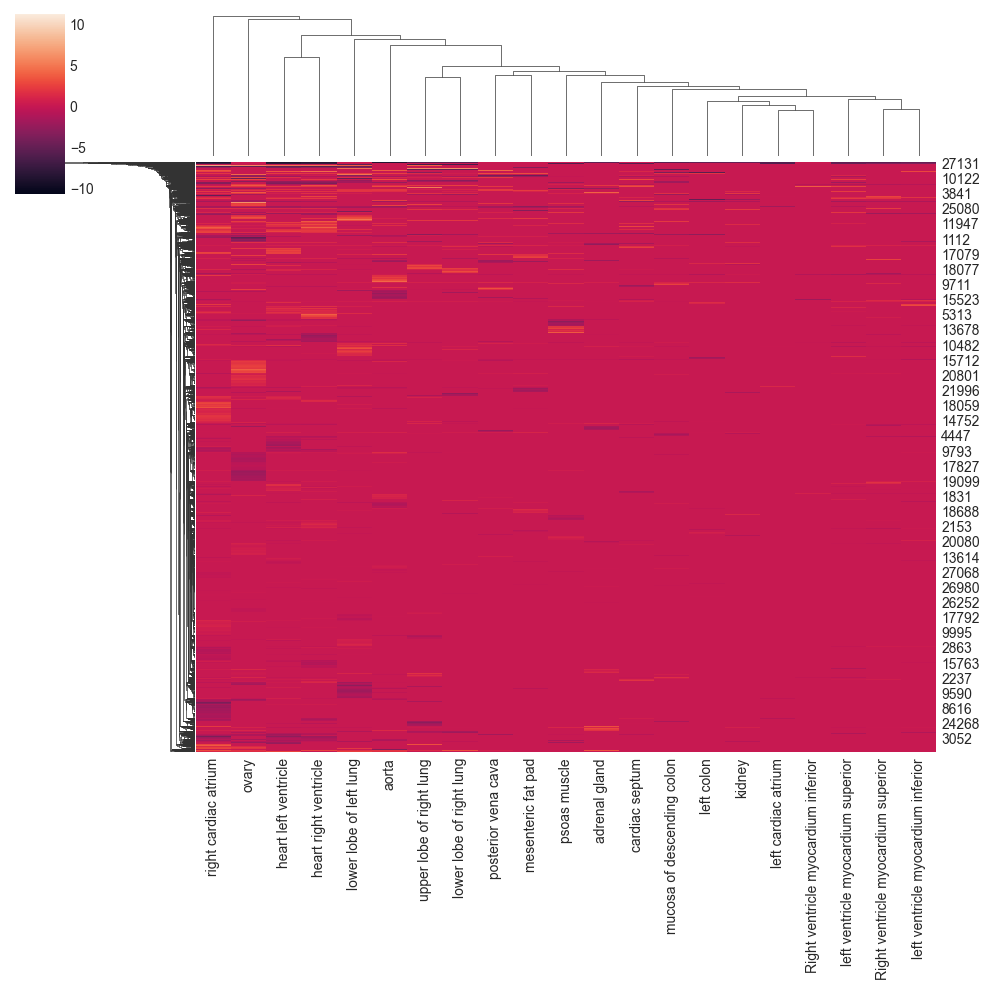

In [239]:
for c in range(1,21):
    sns.clustermap(dist_dfs[c])

# Part 3: Filtering for the most important events

As suggested by Matthias, we will:
* first select those events that pass the filtering over all tissues, that is min_cov>=100.
* then we will retrieve the log2OR for each tissue.

We already have what we need for step 1.

In [4]:
coor_tissue=pd.read_csv("./tables/sample_type/coor_tissue.csv")
eval_trid(coor_tissue)

In [12]:
imp_id=make_event_ids(coor_tissue) # IDs of the important events

  0%|          | 0/64484 [00:00<?, ?it/s]

In [13]:
try:
    isoseq=Transcriptome.load("./theco_isotools.pkl")
    
except FileNotFoundError:    
    try:
        isoseq=Transcriptome.from_reference(anno+".isotools.pkl")
        
    except:
        isoseq=Transcriptome.from_reference(anno+".gtf.gz")
        isoseq.save_reference(anno+'.isotools.pkl')

INFO:loading transcriptome from ./theco_isotools.pkl


In [14]:
import pickle

try:
    with open("./events_dict_nf.pkl","rb") as f:
        events_dict=pickle.load(f)
    
except FileNotFoundError:
    events_dict=isoseq.precompute_events_dict(event_type=("ES","3AS", "5AS","IR","ME", "TSS", "PAS"),min_cov=5)
    with open("./events_dict_nf.pkl","wb") as f:
        pickle.dump(events_dict,f)

In [15]:
stbl=isoseq.sample_table
tissue_names=list(set(stbl[stbl.sample_type=="tissue"].sample_subtype))

In [16]:
groups={}

for tissue in tissue_names:
    groups[tissue]=list(stbl.name[stbl.sample_subtype==tissue])

In [19]:
tbl_path="./tables/tissue_no_filter/"
files=[x.name for x in Path(tbl_path).iterdir()]

tissue_dict_nf={}

for tissue in tissue_names:
    
    tissue_key=tissue.replace(' ','_')
    fname=tissue_key+'.csv'
    
    if fname not in files:
        logger.info(f"computing {fname}")
        tissue_dict_nf[tissue]=isoseq.coordination_test(samples=groups[tissue], test='fisher',
                                                     min_total=5, min_alt_fraction=.01, min_cov_pair=5,
                                                     events_dict=events_dict,query="not NOVEL_GENE")
        tissue_dict_nf[tissue].to_csv(tbl_path+fname,index=False)
    else:
        logger.info(f"reading {fname}")
        tissue_dict_nf[tissue]=pd.read_csv(tbl_path+fname)
        eval_trid(tissue_dict_nf[tissue])

INFO:reading heart_left_ventricle.csv
INFO:reading left_colon.csv
INFO:reading lower_lobe_of_left_lung.csv
INFO:reading cardiac_septum.csv
INFO:computing upper_lobe_of_right_lung.csv
100%|█████████████████████████████████████████████████████████████████| 695092/695092 [31:48<00:00, 364.30genes/s]
INFO:computing mucosa_of_descending_colon.csv
100%|█████████████████████████████████████████████████████████████████| 695092/695092 [12:03<00:00, 960.86genes/s]
INFO:computing right_cardiac_atrium.csv
100%|█████████████████████████████████████████████████████████████████| 695092/695092 [33:44<00:00, 343.36genes/s]
INFO:computing Right_ventricle_myocardium_superior.csv
100%|████████████████████████████████████████████████████████████████| 695092/695092 [08:32<00:00, 1357.20genes/s]
INFO:computing left_cardiac_atrium.csv
100%|████████████████████████████████████████████████████████████████| 695092/695092 [06:17<00:00, 1842.26genes/s]
INFO:computing kidney.csv
100%|███████████████████████████████

In [ ]:
test={k:tab.head(n=100) for k,tab in tissue_dict.items()}

In [ ]:
corr_dict_nf=make_corr_dict(tissue_dict_nf,all_ids=imp_id)

In [ ]:
df=make_cluster_df(test,method="distributed",counts=5*4,corr_dict=corr_dict_nf,all_ids=imp_id)

# Part 4: Reducing the dimensionality